In [28]:
library(DESeq2)
library(ggplot2)
library(reshape2)
library(patchwork)  
library(ggrepel)
library(RColorBrewer)
library(glmpca)
library(pheatmap)
library(PoiClaClu)
library(apeglm)
library(ashr)
library(vsn)
library("pheatmap")
library("ReportingTools")

In [29]:
library("BiocParallel")
register(MulticoreParam(4))

In [30]:
# list.files()
# https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html
# https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#using-sva-with-deseq2

In [31]:
# Load count data
count_data <- read.csv("A549_featureCounts_table_raw_counts_filter_sum_1000_for_deseq2.txt", 
                       sep="\t", header=TRUE, stringsAsFactors=TRUE)  

head(count_data,2)

,Geneid,AC1_IP,AC2_IP,AP1_IP,AP2_IP,AV1_IP,AV2_IP
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000310527.1,110,153,170,166,34,47
2,ENSG00000225880.7,198,319,262,225,99,60


In [32]:
rownames(count_data) <- count_data[,1]  # Set Geneid as row names
count_data <- count_data[,-1]           # Remove Geneid column from dataframe

# Print column names to verify correct loading
print(colnames(count_data))  

# Define conditions based on column names
sample_names <- colnames(count_data)

# Assign groups based on sample name prefixes (AC, AP, AV)
conditions <- ifelse(grepl("^AC", sample_names), "AC",
              ifelse(grepl("^AP", sample_names), "AP",
              ifelse(grepl("^AV", sample_names), "AV", NA)))  

# Ensure no unexpected sample names exist
if (any(is.na(conditions))) {
  stop("Some sample names do not match expected patterns (AC, AP, AV). Check column names!")
}

# Create colData ensuring it matches sample names
col_data <- data.frame(
  row.names = sample_names,
  condition = factor(conditions, levels = c("AP", "AC", "AV"))  # Factor levels for correct comparison
)

dim(count_data)
# Remove rows that contain NA values
count_data <- count_data[complete.cases(count_data), ]
dim(count_data)

head(count_data, 2)
tail(count_data, 2)

[1] "AC1_IP" "AC2_IP" "AP1_IP" "AP2_IP" "AV1_IP" "AV2_IP"


[1] 13185     6

[1] 13183     6

,AC1_IP,AC2_IP,AP1_IP,AP2_IP,AV1_IP,AV2_IP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000310527.1,110,153,170,166,34,47
ENSG00000225880.7,198,319,262,225,99,60


,AC1_IP,AC2_IP,AP1_IP,AP2_IP,AV1_IP,AV2_IP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000291064.2,351,397,275,287,105,78
ENSG00000079974.19,486,617,547,547,207,168


In [33]:
conditions

# Compute summary statistics for each column
summary_stats <- data.frame(
  Median = apply(count_data, 2, median, na.rm = TRUE),
  Min = apply(count_data, 2, min, na.rm = TRUE),
  Max = apply(count_data, 2, max, na.rm = TRUE)
)

# Print results
print(summary_stats)

[1] "AC" "AC" "AP" "AP" "AV" "AV"

       Median Min     Max
AC1_IP    782   0 4204654
AC2_IP   1023   0 4606575
AP1_IP    776   0 3146892
AP2_IP    885   0 5996660
AV1_IP    357   0  783834
AV2_IP    362   0 1449076


In [34]:
# Create DESeq2 dataset
dds <- DESeqDataSetFromMatrix(countData = count_data, colData = col_data, design = ~condition)
dds$condition <- relevel(dds$condition, ref = "AV")

# Run DESeq2 analysis
dds <- DESeq(dds)
res <- results(dds)

head(res, 1)
tail(res, 1)

summary(res)
resultsNames(dds)

# rowRanges(dds)
# colData(dds)
# str(dds)

dds <- estimateSizeFactors(dds)
print("the size factors are:")
sizeFactors(dds)

norm_counts <- counts(dds, normalized = TRUE) 
head(norm_counts, 2)

write.csv(norm_counts, "A549_normalized_counts.csv", row.names = TRUE)

# Compute summary statistics for each column
summary_stats2 <- data.frame(
  Median = apply(norm_counts, 2, median, na.rm = TRUE),
  Min = apply(norm_counts, 2, min, na.rm = TRUE),
  Max = apply(norm_counts, 2, max, na.rm = TRUE)
)

# Print results
print(summary_stats2, 2)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition AC vs AV 
Wald test p-value: condition AC vs AV 
DataFrame with 1 row and 6 columns
                   baseMean log2FoldChange     lfcSE      stat    pvalue
                  <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000310527.1   98.2947       0.417506  0.363403   1.14888  0.250606
                       padj
                  <numeric>
ENSG00000310527.1  0.337133

log2 fold change (MLE): condition AC vs AV 
Wald test p-value: condition AC vs AV 
DataFrame with 1 row and 6 columns
                    baseMean log2FoldChange     lfcSE      stat    pvalue
                   <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000079974.19   381.493       0.293087  0.241104   1.21561  0.224135
                        padj
                   <numeric>
ENSG00000079974.19   0.30709


out of 13138 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3955, 30%
LFC < 0 (down)     : 3689, 28%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Intercept"          "condition_AP_vs_AV" "condition_AC_vs_AV"

[1] "the size factors are:"


AC1_IP    AC2_IP    AP1_IP    AP2_IP    AV1_IP    AV2_IP 
1.1958869 1.5915999 1.2210924 1.3698291 0.5988535 0.5563537

,AC1_IP,AC2_IP,AP1_IP,AP2_IP,AV1_IP,AV2_IP
ENSG00000310527.1,91.98194,96.12969,139.2196,121.1830,56.77516,84.47864
ENSG00000225880.7,165.56750,200.42725,214.5620,164.2541,165.31590,107.84507


         Median Min     Max
AC1_IP 653.9080   0 3515929
AC2_IP 642.7495   0 2894305
AP1_IP 635.4966   0 2577112
AP2_IP 646.0660   0 4377670
AV1_IP 596.1391   0 1308891
AV2_IP 650.6652   0 2604595


In [35]:
# perform additional filtering of the normalized counts 

keep <- rowSums(counts(dds, normalized = TRUE) >= 5) >= 4  # Use counts from 'dds'
table(keep)  # Check how many genes will be kept

dds <- dds[keep, ]  
nrow(dds)    # Confirm the number of remaining genes

keep
FALSE  TRUE 
  267 12916 

[1] 12916

In [36]:
# Get results for different comparisons
res_AP_vs_AC <- results(dds, contrast = c("condition", "AP", "AC"))
res_AP_vs_AV <- results(dds, contrast = c("condition", "AP", "AV"))
res_AC_vs_AV <- results(dds, contrast = c("condition", "AC", "AV"))

summary(res_AP_vs_AV)
summary(res_AC_vs_AV)
summary(res_AP_vs_AC)

# perform additional filtering of the normalized counts 

# keep <- rowSums(counts(dds, normalized = TRUE) >= 5) >= 4  # Use counts from 'dds'
# table(keep)  # Check how many genes will be kept

# dds <- dds[keep, ]  
# nrow(dds)    # Confirm the number of remaining genes

# Save results
write.csv(as.data.frame(res_AP_vs_AC), file = "A549.DESeq2_AP_vs_AC_results.csv")
write.csv(as.data.frame(res_AP_vs_AV), file = "A549.DESeq2_AP_vs_AV_results.csv")
write.csv(as.data.frame(res_AC_vs_AV), file = "A549.DESeq2_AC_vs_AV_results.csv")

###########################################################
###########################################################
resultsNames(dds)
###########################################################
###########################################################

print("number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05")
dim(subset(res_AP_vs_AC, pvalue < 0.05))
dim(subset(res_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05")
dim(subset(res_AP_vs_AV, pvalue < 0.05))
dim(subset(res_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05")
dim(subset(res_AC_vs_AV, pvalue < 0.05))
dim(subset(res_AC_vs_AV, padj < 0.1))


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4100, 32%
LFC < 0 (down)     : 3749, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3955, 31%
LFC < 0 (down)     : 3683, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 351, 2.7%
LFC < 0 (down)     : 94, 0.73%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Intercept"          "condition_AP_vs_AV" "condition_AC_vs_AV"

[1] "number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05"


[1] 1327    6

[1] 445   6

[1] "number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05"


[1] 7599    6

[1] 7849    6

[1] "number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05"


[1] 7440    6

[1] 7638    6

In [37]:
# type = c("apeglm", "ashr", "normal"),

In [38]:
# If you must use contrast, you should use type="normal" or type="ashr" instead of apeglm, 
# because apeglm only works with coef.  
# Apeglm is the recommended method for log-fold change shrinkage.

# Get results for different comparisons
# resLFCapeglm_AP_vs_AV <- lfcShrink(dds, coef = "condition_AP_vs_AV", type="apeglm")
# resLFCapeglm_AC_vs_AV <- lfcShrink(dds, coef = "condition_AC_vs_AV", type="apeglm")

resLFCashr_AP_vs_AV <- lfcShrink(dds, contrast = c("condition", "AP", "AV"), type="ashr")
resLFCashr_AC_vs_AV <- lfcShrink(dds, contrast = c("condition", "AC", "AV"), type="ashr")
resLFCashr_AP_vs_AC <- lfcShrink(dds, contrast = c("condition", "AP", "AC"), type="ashr")

summary(resLFCashr_AP_vs_AV)
summary(resLFCashr_AC_vs_AV)
summary(resLFCashr_AP_vs_AC)

# Save results
write.csv(as.data.frame(resLFCashr_AP_vs_AC), file = "A549.DESeq2_AP_vs_AC_results.resLFCashr.csv")
write.csv(as.data.frame(resLFCashr_AP_vs_AV), file = "A549.DESeq2_AP_vs_AV_results.resLFCashr.csv")
write.csv(as.data.frame(resLFCashr_AC_vs_AV), file = "A549.DESeq2_AC_vs_AV_results.resLFCashr.csv")

###########################################################
###########################################################
resultsNames(dds)
###########################################################
###########################################################

print("number of differentially bound and expressed transcripts : resLFCashr : AP vs AC : pvalue < 0.05")
dim(subset(resLFCashr_AP_vs_AC, pvalue < 0.05))
dim(subset(resLFCashr_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : resLFCashr : AP vs AV : pvalue < 0.05")
dim(subset(resLFCashr_AP_vs_AV, pvalue < 0.05))
dim(subset(resLFCashr_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : resLFCashr : AC vs AV : pvalue < 0.05")
dim(subset(resLFCashr_AC_vs_AV, pvalue < 0.05))
dim(subset(resLFCashr_AC_vs_AV, padj < 0.1))

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4100, 32%
LFC < 0 (down)     : 3749, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3955, 31%
LFC < 0 (down)     : 3683, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 351, 2.7%
LFC < 0 (down)     : 94, 0.73%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Intercept"          "condition_AP_vs_AV" "condition_AC_vs_AV"

[1] "number of differentially bound and expressed transcripts : resLFCashr : AP vs AC : pvalue < 0.05"


[1] 1327    5

[1] 445   5

[1] "number of differentially bound and expressed transcripts : resLFCashr : AP vs AV : pvalue < 0.05"


[1] 7599    5

[1] 7849    5

[1] "number of differentially bound and expressed transcripts : resLFCashr : AC vs AV : pvalue < 0.05"


[1] 7440    5

[1] 7638    5

In [29]:
# Get results for different comparisons

resLFCnormal_AP_vs_AV <- lfcShrink(dds, contrast = c("condition", "AP", "AV"), type="normal")
resLFCnormal_AC_vs_AV <- lfcShrink(dds, contrast = c("condition", "AC", "AV"), type="normal")
resLFCnormal_AP_vs_AC <- lfcShrink(dds, contrast = c("condition", "AP", "AC"), type="normal")

summary(resLFCnormal_AP_vs_AV)
summary(resLFCnormal_AC_vs_AV)
summary(resLFCnormal_AP_vs_AC)

# Save results
write.csv(as.data.frame(resLFCnormal_AP_vs_AC), file = "A549.DESeq2_AP_vs_AC_results.resLFCnormal.csv")
write.csv(as.data.frame(resLFCnormal_AP_vs_AV), file = "A549.DESeq2_AP_vs_AV_results.resLFCnormal.csv")
write.csv(as.data.frame(resLFCnormal_AC_vs_AV), file = "A549.DESeq2_AC_vs_AV_results.resLFCnormal.csv")

###########################################################
###########################################################
resultsNames(dds)
###########################################################
###########################################################

print("number of differentially bound and expressed transcripts : resLFCnormal: AP vs AC : pvalue < 0.05")
dim(subset(resLFCnormal_AP_vs_AC, pvalue < 0.05))
dim(subset(resLFCnormal_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : resLFCnormal : AP vs AV : pvalue < 0.05")
dim(subset(resLFCnormal_AP_vs_AV, pvalue < 0.05))
dim(subset(resLFCnormal_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : resLFCashr : AC vs AV : pvalue < 0.05")
dim(subset(resLFCnormal_AC_vs_AV, pvalue < 0.05))
dim(subset(resLFCnormal_AC_vs_AV, padj < 0.1))

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4100, 32%
LFC < 0 (down)     : 3749, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3955, 31%
LFC < 0 (down)     : 3683, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 351, 2.7%
LFC < 0 (down)     : 94, 0.73%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Intercept"          "condition_AP_vs_AV" "condition_AC_vs_AV"

[1] "number of differentially bound and expressed transcripts : resLFCnormal: AP vs AC : pvalue < 0.05"


[1] 1327    6

[1] 445   6

[1] "number of differentially bound and expressed transcripts : resLFCnormal : AP vs AV : pvalue < 0.05"


[1] 7599    6

[1] 7849    6

[1] "number of differentially bound and expressed transcripts : resLFCashr : AC vs AV : pvalue < 0.05"


[1] 7440    6

[1] 7638    6

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
"Removed 10727 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 9600 rows containing non-finite outside the scale range (`stat_boxplot()`)."


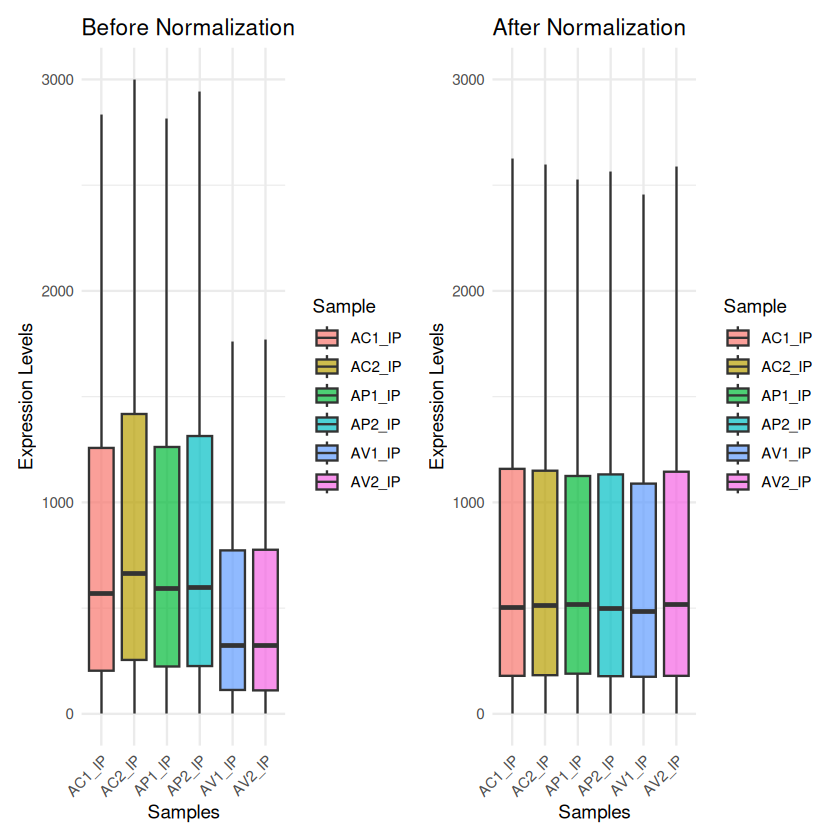

In [39]:
# Convert original count data to long format
df_long_before <- melt(as.data.frame(count_data), variable.name = "Sample", value.name = "Expression")
df_long_before$Status <- "Before Normalization" 
# Convert normalized data to long format
df_long_after <- melt(as.data.frame(norm_counts), variable.name = "Sample", value.name = "Expression")
df_long_after$Status <- "After Normalization"  

# Create boxplot for BEFORE normalization
p_before <- ggplot(df_long_before, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.7) +
  theme_minimal() +
  labs(title = "Before Normalization", x = "Samples", y = "Expression Levels") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, 3000)  

# Create boxplot for AFTER normalization
p_after <- ggplot(df_long_after, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.7) +
  theme_minimal() +
  labs(title = "After Normalization", x = "Samples", y = "Expression Levels") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, 3000)

# Display plots separately (side by side)
p_before + p_after

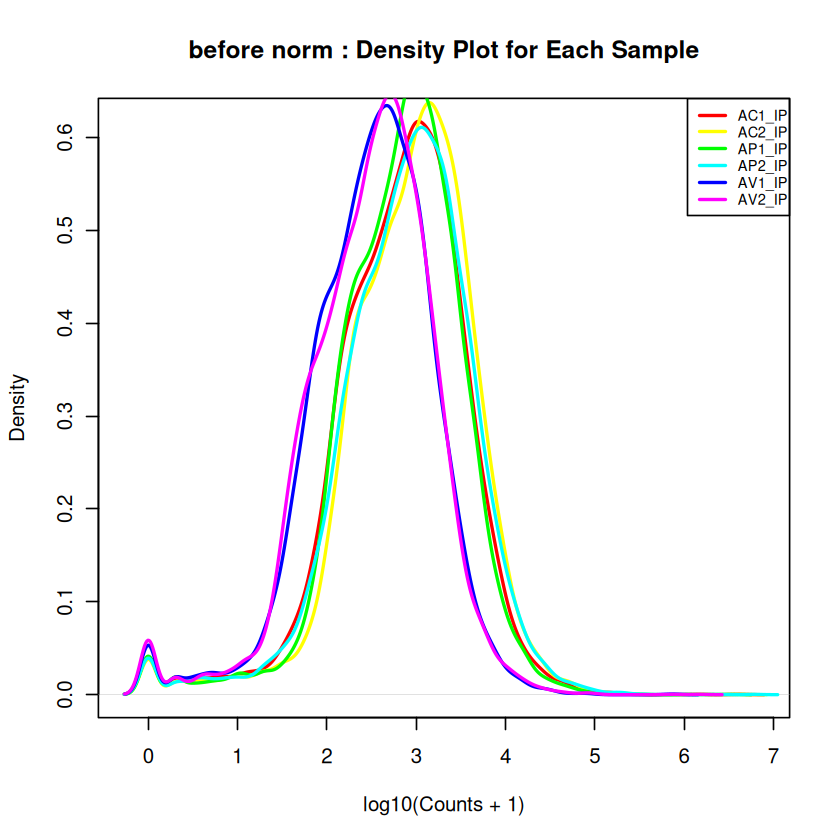

In [40]:
# Extract raw counts (log-transformed) from DESeq2 object
count_data_log <- log10(count_data + 1)

# Define colors for each sample
colors <- rainbow(ncol(count_data_log))  

# Plot the first sample density
plot(density(count_data_log[, 1]), col = colors[1], lwd = 2,
     main = "before norm : Density Plot for Each Sample",
     xlab = "log10(Counts + 1)", ylab = "Density", ylim = c(0, max(density(count_data_log[, 1])$y)))

# Add density plots for the remaining samples
for (i in 2:ncol(count_data_log)) {
  lines(density(count_data_log[, i]), col = colors[i], lwd = 2)
}

# Add legend
legend("topright", legend = colnames(count_data_log), col = colors, lwd = 2, cex = 0.7)

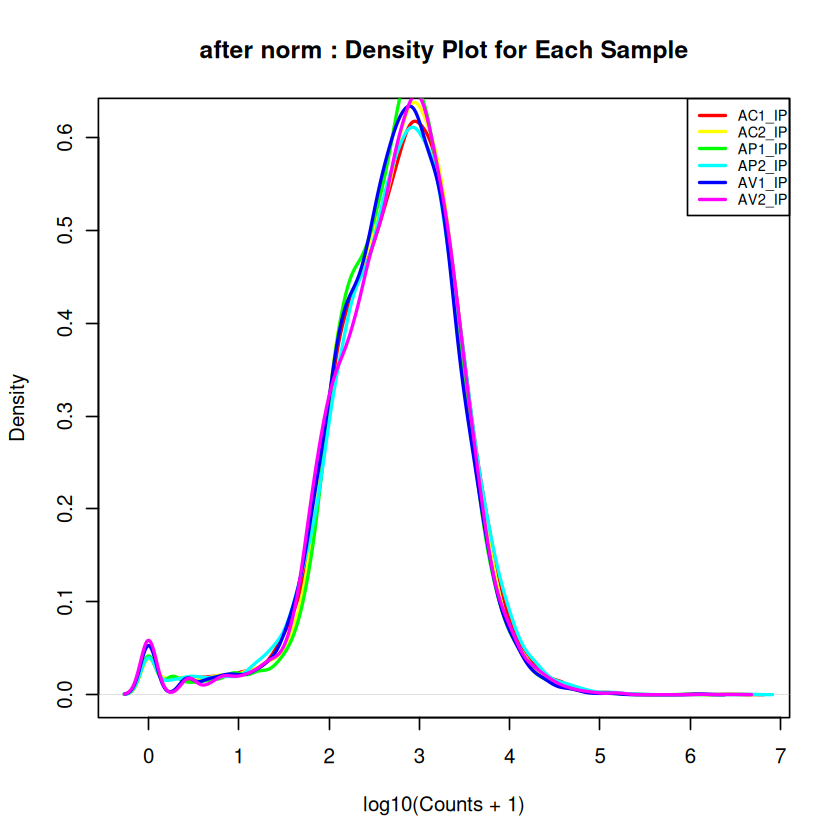

In [41]:
# Extract normalized counts (log-transformed) from DESeq2 object
count_data2_log <- log10(norm_counts + 1)

# Define colors for each sample
colors <- rainbow(ncol(count_data2_log))  

# Plot the first sample density
plot(density(count_data2_log[, 1]), col = colors[1], lwd = 2,
     main = "after norm : Density Plot for Each Sample",
     xlab = "log10(Counts + 1)", ylab = "Density", 
     ylim = c(0, max(density(count_data_log[, 1])$y)))

# Add density plots for the remaining samples
for (i in 2:ncol(count_data2_log)) {
  lines(density(count_data2_log[, i]), col = colors[i], lwd = 2)
}

# Add legend
legend("topright", legend = colnames(count_data2_log), col = colors, lwd = 2, cex = 0.7)


In [42]:
# Print full summary statistics of the data frame
summary(count_data)

# Compute min, max, and median for each column (sample)
summary_stats <- data.frame(
  Sample = colnames(count_data),
  Min = apply(count_data, 2, min, na.rm = TRUE),
  Max = apply(count_data, 2, max, na.rm = TRUE),
  Median = apply(count_data, 2, median, na.rm = TRUE)
)

# Print the summary table
print(summary_stats)

# Print full summary statistics of the data frame
summary(norm_counts)

# Compute min, max, and median for each column (sample)
summary_stats2 <- data.frame(
  Sample = colnames(norm_counts),
  Min = apply(norm_counts, 2, min, na.rm = TRUE),
  Max = apply(norm_counts, 2, max, na.rm = TRUE),
  Median = apply(norm_counts, 2, median, na.rm = TRUE)
)

# Print the summary table
print(summary_stats2)

     AC1_IP            AC2_IP            AP1_IP            AP2_IP       
 Min.   :      0   Min.   :      0   Min.   :      0   Min.   :      0  
 1st Qu.:    252   1st Qu.:    343   1st Qu.:    269   1st Qu.:    290  
 Median :    782   Median :   1023   Median :    776   Median :    885  
 Mean   :   2548   Mean   :   3085   Mean   :   2239   Mean   :   3157  
 3rd Qu.:   2012   3rd Qu.:   2569   3rd Qu.:   1882   3rd Qu.:   2292  
 Max.   :4204654   Max.   :4606575   Max.   :3146892   Max.   :5996660  
     AV1_IP             AV2_IP         
 Min.   :     0.0   Min.   :      0.0  
 1st Qu.:   122.0   1st Qu.:    118.0  
 Median :   357.0   Median :    362.0  
 Mean   :  1011.1   Mean   :   1090.3  
 3rd Qu.:   904.5   3rd Qu.:    894.5  
 Max.   :783834.0   Max.   :1449076.0  

       Sample Min     Max Median
AC1_IP AC1_IP   0 4204654    782
AC2_IP AC2_IP   0 4606575   1023
AP1_IP AP1_IP   0 3146892    776
AP2_IP AP2_IP   0 5996660    885
AV1_IP AV1_IP   0  783834    357
AV2_IP AV2_IP   0 1449076    362


     AC1_IP            AC2_IP              AP1_IP              AP2_IP       
 Min.   :      0   Min.   :      0.0   Min.   :      0.0   Min.   :      0  
 1st Qu.:    211   1st Qu.:    215.5   1st Qu.:    220.3   1st Qu.:    212  
 Median :    654   Median :    642.7   Median :    635.5   Median :    646  
 Mean   :   2130   Mean   :   1938.1   Mean   :   1833.4   Mean   :   2304  
 3rd Qu.:   1682   3rd Qu.:   1614.1   3rd Qu.:   1541.2   3rd Qu.:   1673  
 Max.   :3515929   Max.   :2894304.6   Max.   :2577112.2   Max.   :4377670  
     AV1_IP              AV2_IP         
 Min.   :      0.0   Min.   :      0.0  
 1st Qu.:    203.7   1st Qu.:    212.1  
 Median :    596.1   Median :    650.7  
 Mean   :   1688.4   Mean   :   1959.6  
 3rd Qu.:   1510.4   3rd Qu.:   1607.8  
 Max.   :1308891.1   Max.   :2604595.0  

       Sample Min     Max   Median
AC1_IP AC1_IP   0 3515929 653.9080
AC2_IP AC2_IP   0 2894305 642.7495
AP1_IP AP1_IP   0 2577112 635.4966
AP2_IP AP2_IP   0 4377670 646.0660
AV1_IP AV1_IP   0 1308891 596.1391
AV2_IP AV2_IP   0 2604595 650.6652


In [16]:
dim(norm_counts)
head(norm_counts)

[1] 13183     6

,AC1_IP,AC2_IP,AP1_IP,AP2_IP,AV1_IP,AV2_IP
ENSG00000310527.1,91.98194,96.12969,139.21961,121.1830,56.77516,84.47864
ENSG00000225880.7,165.56750,200.42725,214.56199,164.2541,165.31590,107.84507
ENSG00000225630.1,2319.61735,1181.20137,1651.79971,2353.5783,522.66541,1139.56288
ENSG00000237973.1,827.00128,789.77134,749.32907,1040.2758,624.52673,612.91947
ENSG00000229344.1,132.11952,104.29757,86.80752,157.6839,80.15316,89.87089
ENSG00000248527.1,7728.15556,5779.09052,6530.21858,6366.4878,4177.98360,5780.49560


In [43]:
resultsNames(dds)

print("number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05")
dim(subset(res_AP_vs_AC, pvalue < 0.05))
dim(subset(res_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05")
dim(subset(res_AP_vs_AV, pvalue < 0.05))
dim(subset(res_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05")
dim(subset(res_AC_vs_AV, pvalue < 0.05))
dim(subset(res_AC_vs_AV, padj < 0.1))

[1] "Intercept"          "condition_AP_vs_AV" "condition_AC_vs_AV"

[1] "number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05"


[1] 1327    6

[1] 445   6

[1] "number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05"


[1] 7599    6

[1] 7849    6

[1] "number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05"


[1] 7440    6

[1] 7638    6

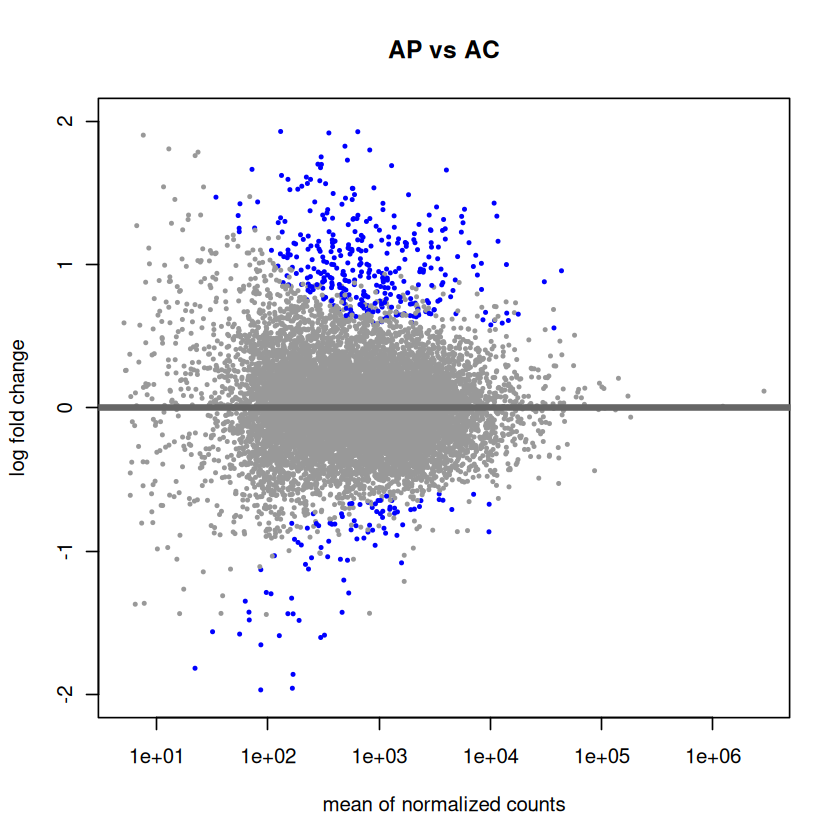

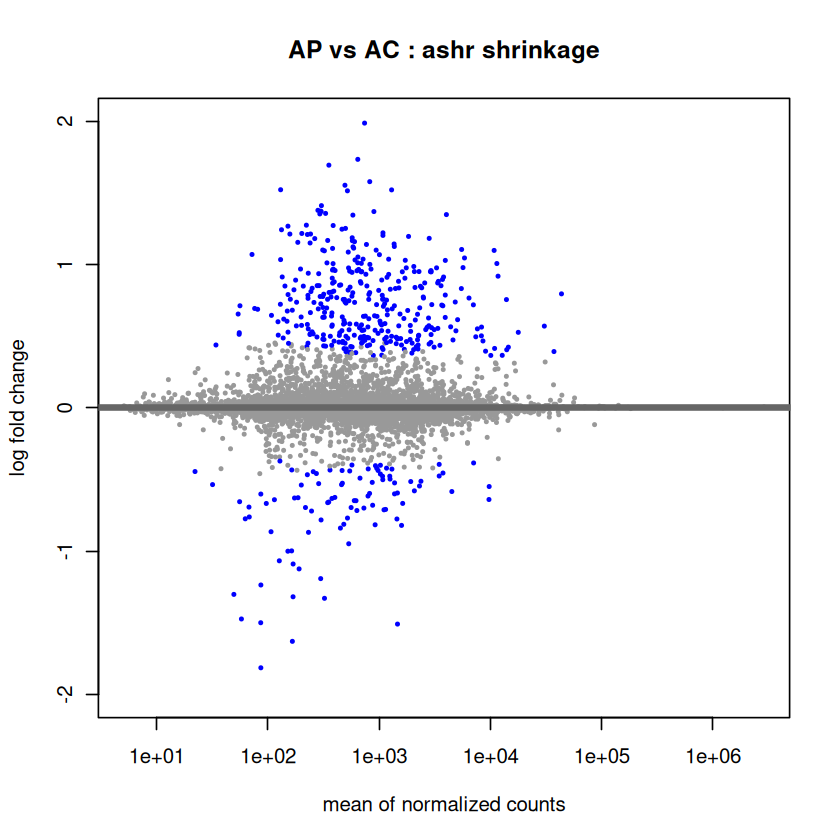

In [44]:
####################### MA plots

res_AP_vs_AC_filtered <- res_AP_vs_AC[which(res_AP_vs_AC$log2FoldChange > -2 & res_AP_vs_AC$log2FoldChange < 2),]
plotMA(res_AP_vs_AC_filtered, main="AP vs AC", ylim=c(-2,2))

# Filter results where log2FoldChange is between -2 and 2, while removing NAs
resLFCashr_AP_vs_AC_filtered <- na.omit(resLFCashr_AP_vs_AC[which(resLFCashr_AP_vs_AC$log2FoldChange > -2 & 
                                                                 resLFCashr_AP_vs_AC$log2FoldChange < 2), ])
# Plot MA plot for AP vs AC
plotMA(resLFCashr_AP_vs_AC_filtered, main="AP vs AC : ashr shrinkage", ylim=c(-2,2))

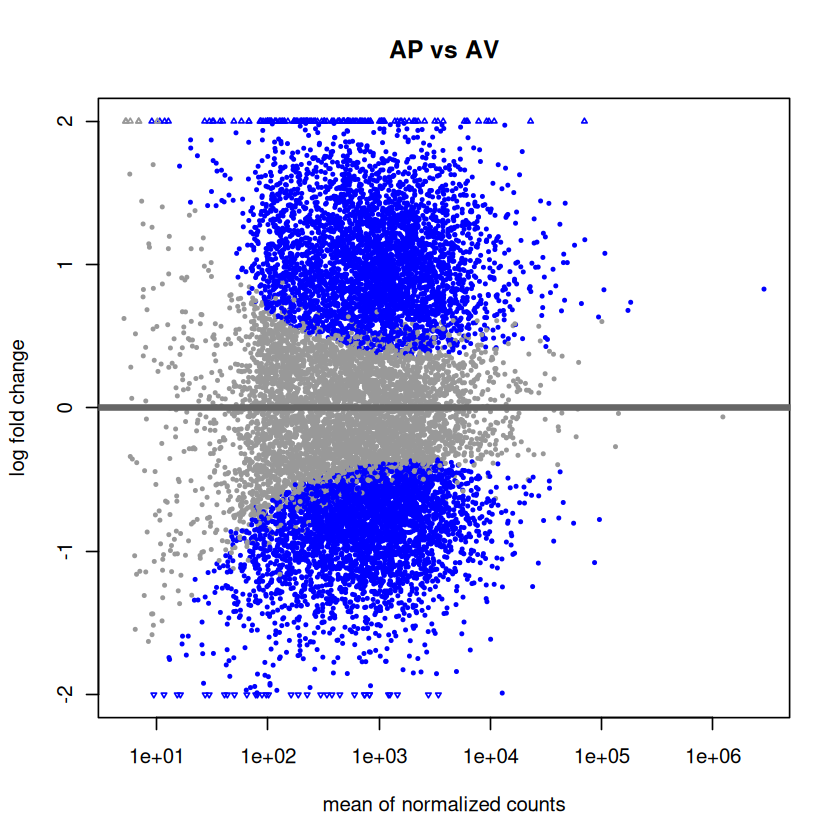

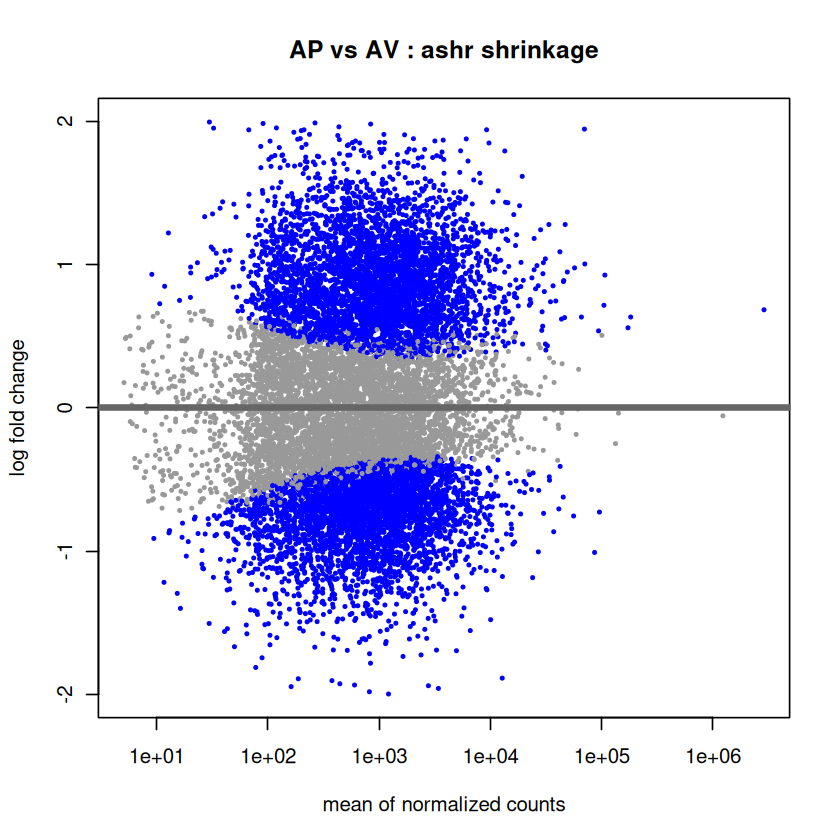

In [45]:
####################### MA plots

res_AP_vs_AV_filtered <- res_AP_vs_AV[which(res_AP_vs_AV$log2FoldChange > -2 & res_AP_vs_AV$log2FoldChange < 2),]
plotMA(res_AP_vs_AV, main="AP vs AV", ylim=c(-2,2))

# Corrected filtering for AP vs AV (fixed typo in object name)
resLFCashr_AP_vs_AV_filtered <- na.omit(resLFCashr_AP_vs_AV[which(resLFCashr_AP_vs_AV$log2FoldChange > -2 & 
                                                                 resLFCashr_AP_vs_AV$log2FoldChange < 2), ])
# Plot MA plot for AP vs AV
plotMA(resLFCashr_AP_vs_AV_filtered, main="AP vs AV : ashr shrinkage", ylim=c(-2,2))

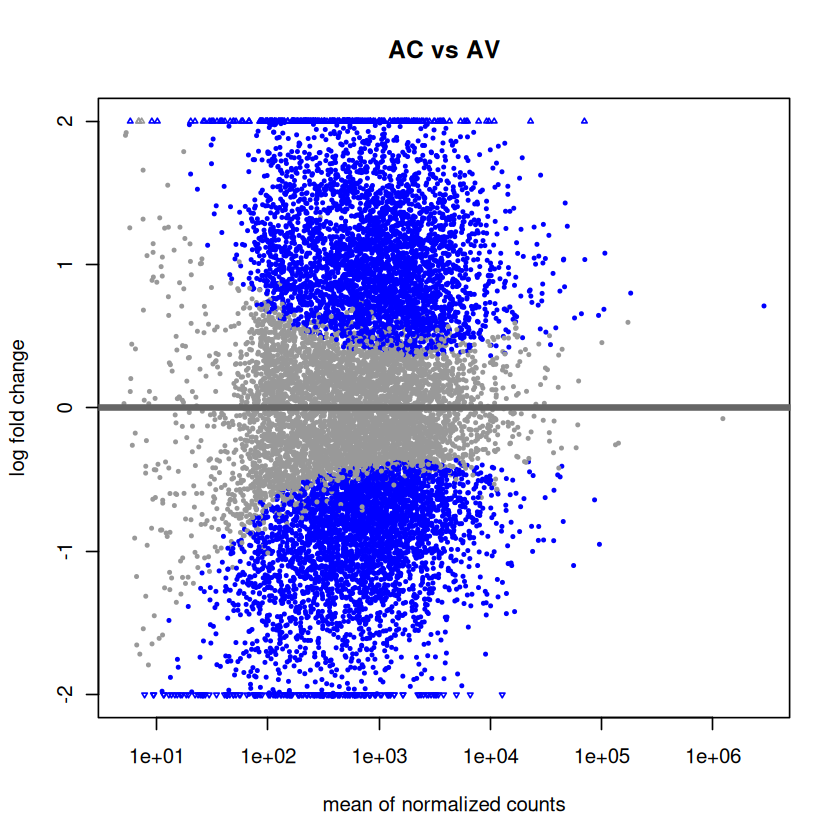

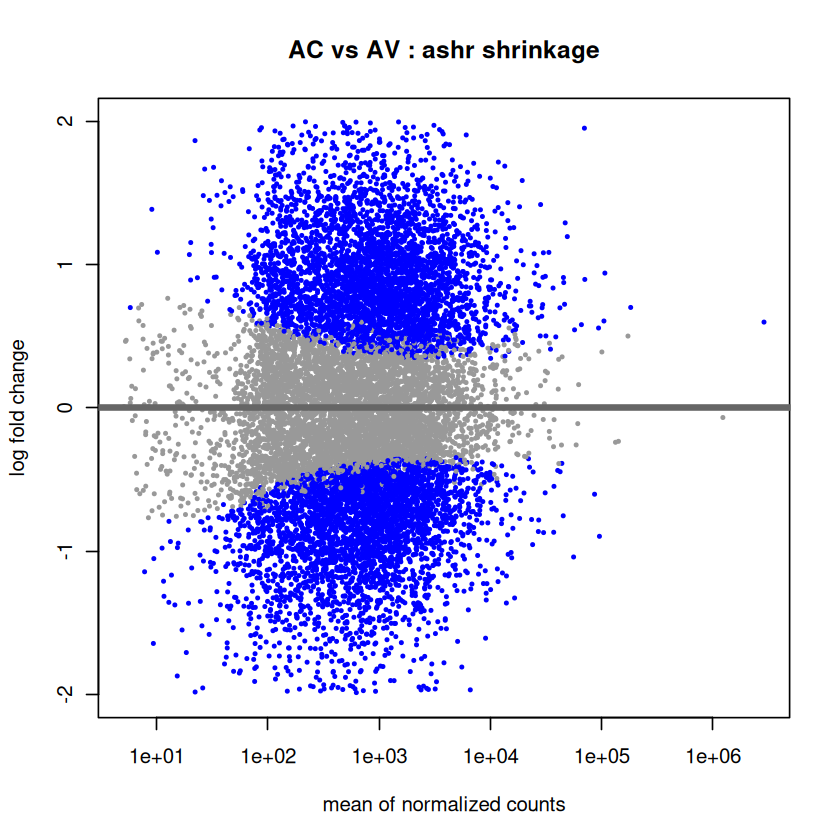

In [46]:
####################### MA plots

res_AC_vs_AV_filtered <- res_AC_vs_AV[which(res_AC_vs_AV$log2FoldChange > -2 & res_AC_vs_AV$log2FoldChange < 2),]
plotMA(res_AC_vs_AV, main="AC vs AV", ylim=c(-2,2))

# Corrected filtering for AC vs AV
resLFCashr_AC_vs_AV_filtered <- na.omit(resLFCashr_AC_vs_AV[which(resLFCashr_AC_vs_AV$log2FoldChange > -2 & 
                                                                 resLFCashr_AC_vs_AV$log2FoldChange < 2), ])
# Plot MA plot for AC vs AV
plotMA(resLFCashr_AC_vs_AV_filtered, main="AC vs AV : ashr shrinkage", ylim=c(-2,2))

In [22]:
print("plotting dispersion")

[1] "plotting dispersion"


function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x587dca1983c8>
<environment: 0x587dd0623318>
attr(,"coefficients")
asymptDisp  extraPois 
0.02891376 3.57487070 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 1.508598
attr(,"dispPriorVar")
[1] 0.4164164

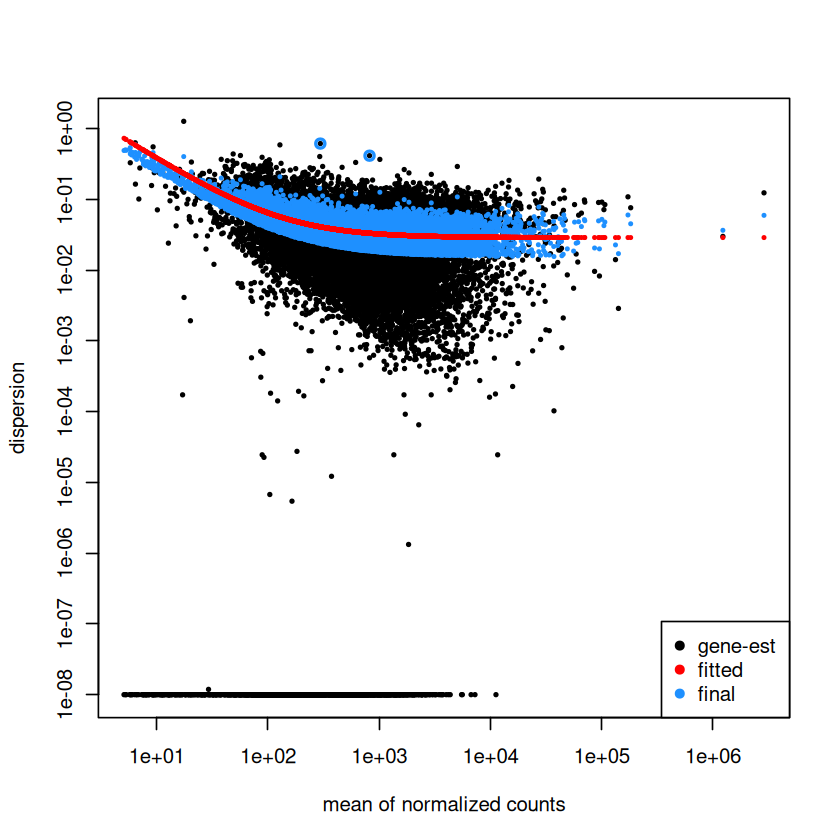

In [47]:
plotDispEsts(dds)
dispersionFunction(dds)

In [24]:
# In order to test for differential expression, we operate on raw counts and use discrete distributions as described 
# in the previous section on differential expression. 
# However for other downstream analyses – e.g. for visualization or clustering – 
# it might be useful to work with transformed versions of the count data.

# Maybe the most obvious choice of transformation is the logarithm. Since count values for a gene can be zero in 
# some conditions (and non-zero in others), some advocate the use of pseudocounts.

# One makes use of the concept of variance stabilizing transformations (VST) (Tibshirani 1988; Huber et al. 2003; Anders and Huber 2010),
# and the other is the regularized logarithm or rlog, which incorporates a prior on the sample differences (Love, Huber, and Anders 2014). 
# Both transformations produce transformed data on the log2 scale which has been normalized with respect to library size or 
# other normalization factors.

In [48]:
# Why Are These Transformations Needed?

# RNA-seq count data exhibits a strong mean-variance relationship: genes with low counts tend to have high variance, 
# while genes with high counts tend to have lower relative variance.

# The point of these two transformations, the VST and the rlog, is to remove the dependence of the variance on the mean, 
# particularly the high variance of the logarithm of count data when the mean is low.

# By setting blind to FALSE, the dispersions already estimated will be used to perform transformations, 
# or if not present, they will be estimated using the current design formula.

# Extracting the transformed values : the assay function is used to extract the matrix of normalized values.
# vsd <- vst(dds, blind=FALSE)
# rld <- rlog(dds, blind=FALSE)

In [51]:
# Effects of transformations on the variance

rld <- rlog(dds, blind = FALSE)  
vsd <- vst(dds, blind = FALSE) 
ntd <- normTransform(dds)
# meanSdPlot(assay(ntd))
# meanSdPlot(assay(rld))
# meanSdPlot(assay(vsd))

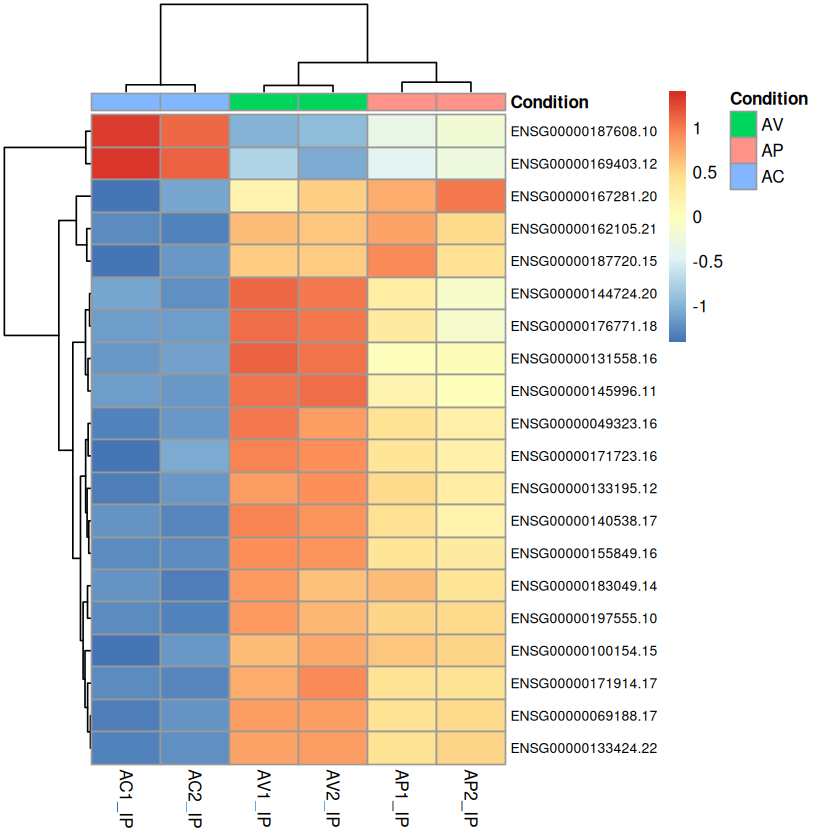

In [52]:
library("pheatmap")

# Select the top 20 differentially expressed genes based on adjusted p-value
top_genes <- rownames(res_AP_vs_AC)[order(res_AP_vs_AC$padj, na.last=NA)][1:20]  #

# Extract normalized transformed counts for the top genes
top_counts <- assay(vsd)[top_genes, ]

# Create annotation dataframe
df <- as.data.frame(colData(dds)["condition"])  # Ensure it is a proper dataframe
colnames(df) <- "Condition"  # Rename column for clarity

# Generate heatmap
pheatmap(top_counts, 
         cluster_rows=TRUE,  # Cluster rows to group similar genes
         show_rownames=TRUE,  # Show gene names
         cluster_cols=TRUE,  # Cluster samples
         annotation_col=df,  # Add sample condition annotations
         scale="row",  # Normalize each gene's expression across samples
         fontsize_row=8)  # Adjust row text size for readability

In [53]:
print("PCA plot of rld-transformed counts")

[1] "PCA plot of rld-transformed counts"


using ntop=500 top features by variance



[1] "MDS plot of rld-transformed counts"


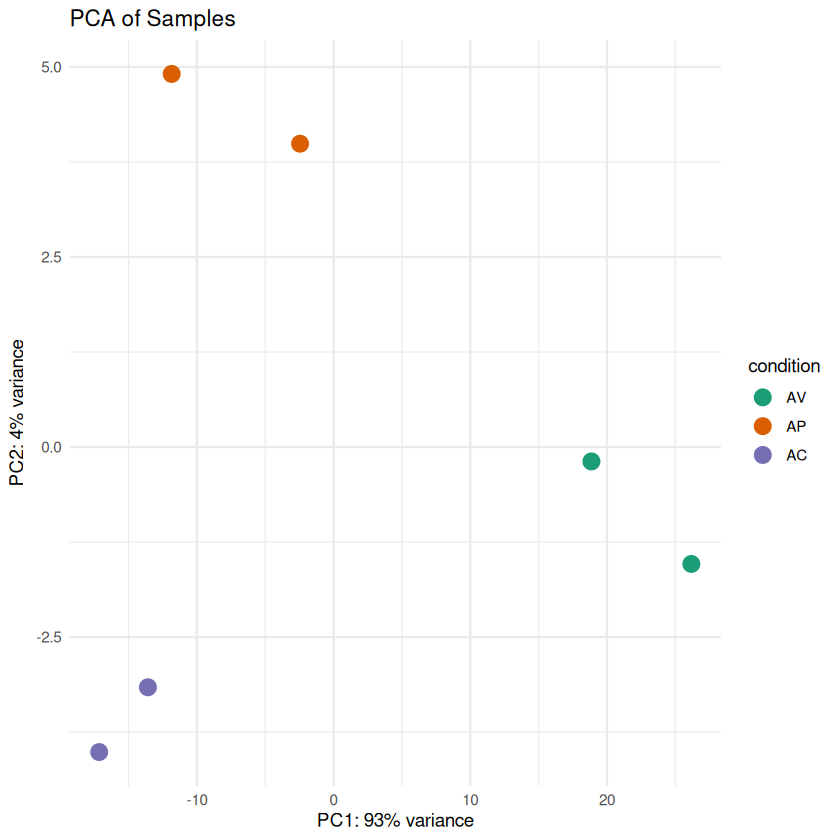

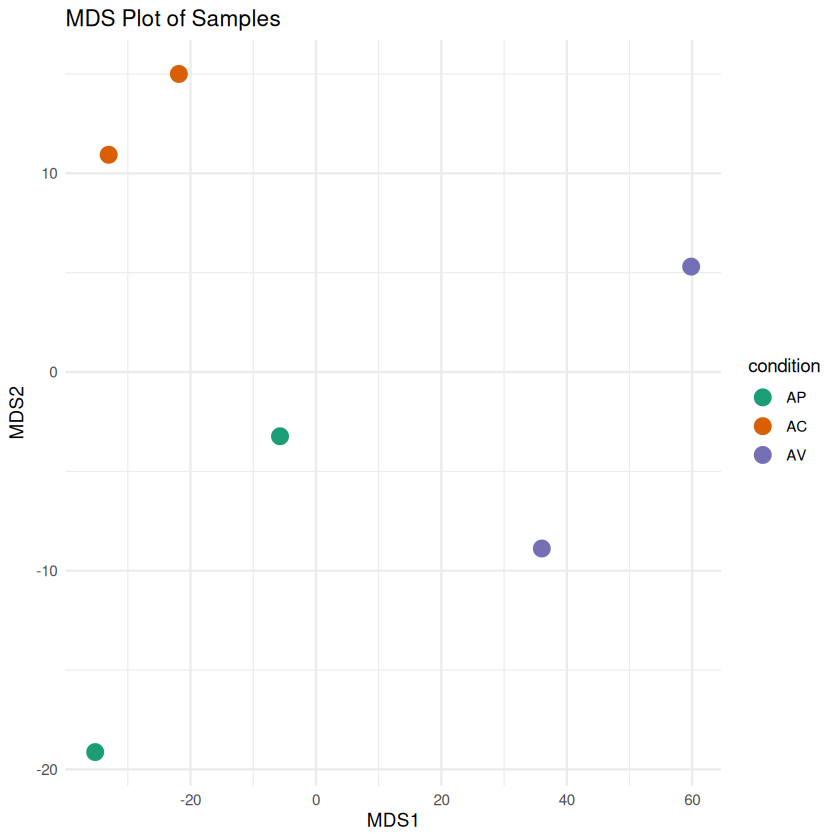

In [54]:
rld <- rlog(dds, blind = FALSE)  # Regularized log transformation
pcaData <- plotPCA(rld, intgroup="condition", returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(PC1, PC2, color=condition)) +
  geom_point(size=4) +
  scale_color_brewer(palette="Dark2") +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  ggtitle("PCA of Samples") +
  theme_minimal()

print("MDS plot of rld-transformed counts")

sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
mdsData <- cmdscale(sampleDistMatrix)
mds_df <- data.frame(MDS1 = mdsData[,1], MDS2 = mdsData[,2], condition = col_data$condition)

ggplot(mds_df, aes(MDS1, MDS2, color=condition)) +
  geom_point(size=4) +
  scale_color_brewer(palette="Dark2") +
  ggtitle("MDS Plot of Samples") +
  theme_minimal()

In [55]:
print("PCA plot of vst-transformed counts")

[1] "PCA plot of vst-transformed counts"


using ntop=500 top features by variance



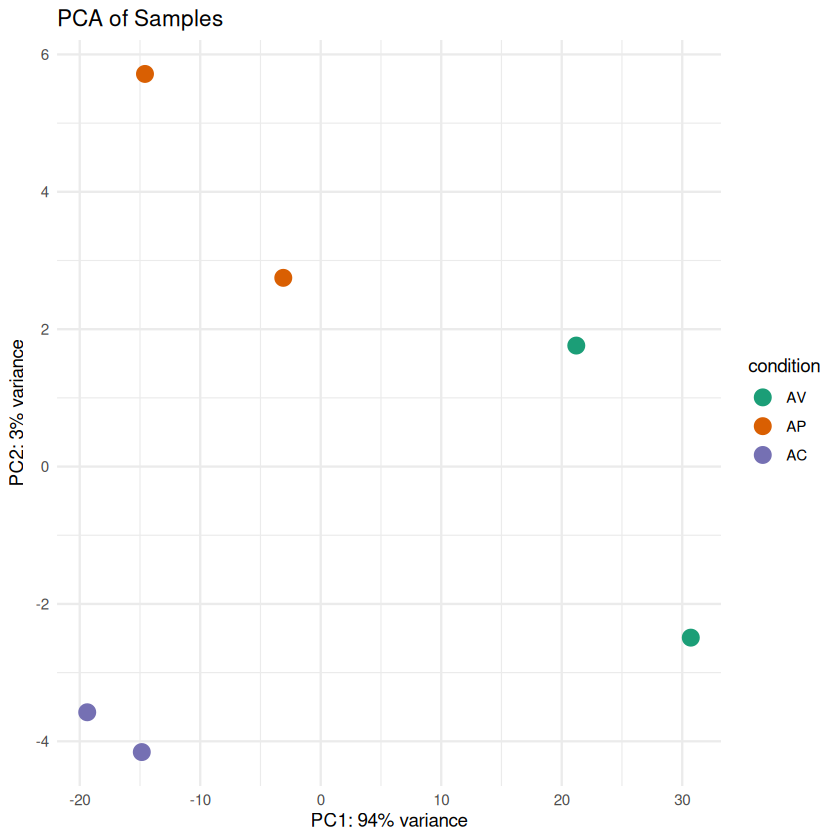

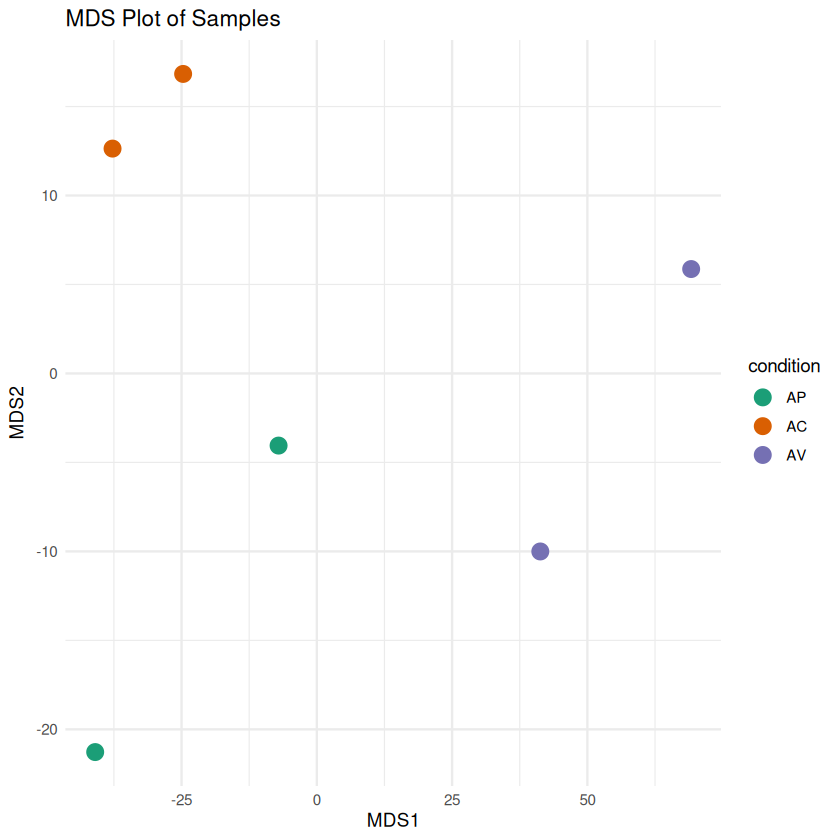

In [56]:
vsd <- vst(dds, blind = FALSE) 
pcaData <- plotPCA(vsd, intgroup="condition", returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(PC1, PC2, color=condition)) +
  geom_point(size=4) +
  scale_color_brewer(palette="Dark2") +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  ggtitle("PCA of Samples") +
  theme_minimal()

# MDS Plot
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
mdsData <- cmdscale(sampleDistMatrix)
mds_df <- data.frame(MDS1 = mdsData[,1], MDS2 = mdsData[,2], condition = col_data$condition)

ggplot(mds_df, aes(MDS1, MDS2, color=condition)) +
  geom_point(size=4) +
  scale_color_brewer(palette="Dark2") +
  ggtitle("MDS Plot of Samples") +
  theme_minimal()

In [65]:
# str(dds)

[1] "PCA by using GLMPCA library. RLOG and VSD transformation are more suitable than SCALE() function."
'data.frame':	6 obs. of  4 variables:
 $ dim1     : num  -29.07 -17.94 -6.09 -35.29 57.08 ...
 $ dim2     : num  -14.16 -17.49 2.79 15.46 2.28 ...
 $ sample   : chr  "AC1_IP" "AC2_IP" "AP1_IP" "AP2_IP" ...
 $ condition: Factor w/ 3 levels "AV","AP","AC": 3 3 2 2 1 1


,dim1,dim2,sample,condition
,<dbl>,<dbl>,<chr>,<fct>
AC1_IP,-29.07198,-14.16393,AC1_IP,AC
AC2_IP,-17.94166,-17.48925,AC2_IP,AC


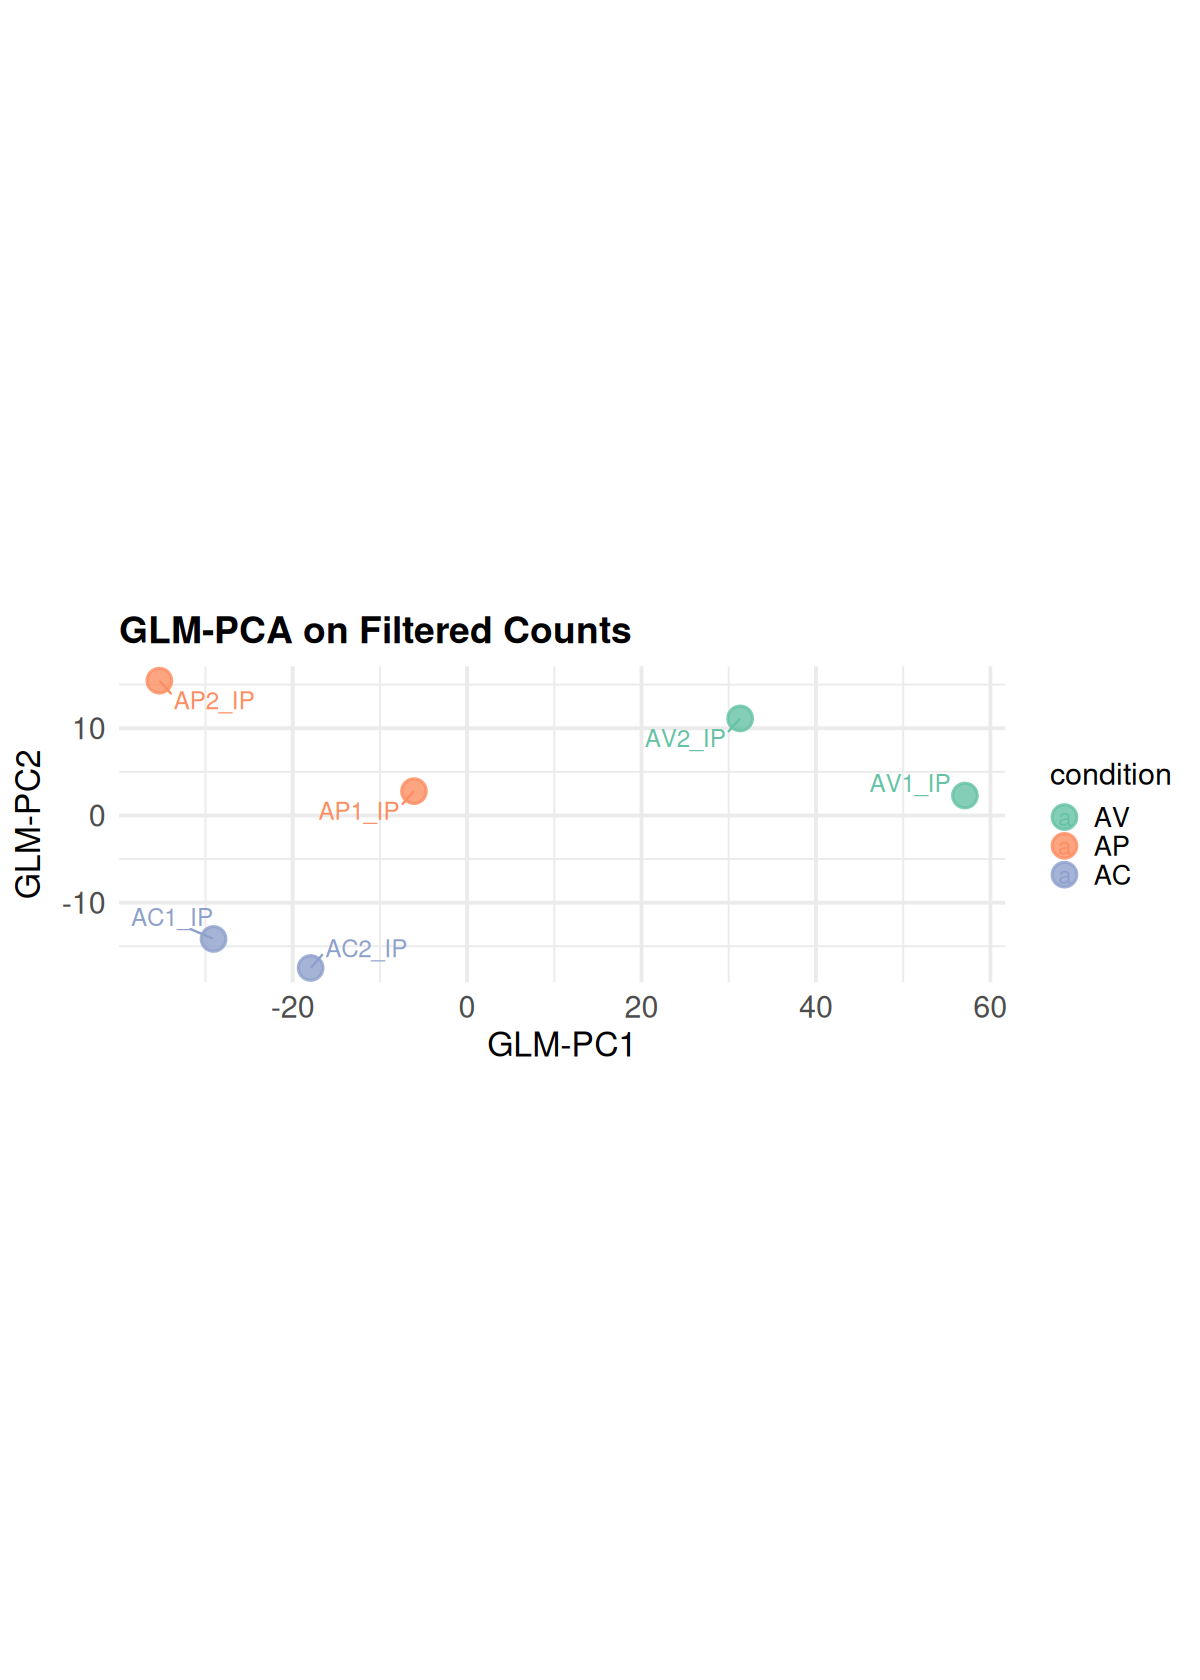

In [58]:
print("PCA by using GLMPCA library. RLOG and VSD transformation are more suitable than SCALE() function.")
options(repr.plot.width = 10, repr.plot.height = 14)

gpca <- glmpca(assay(dds), L=2)
gpca.dat <- gpca$factors

# Ensure gpca.dat has correct sample metadata
gpca.dat$sample <- colnames(dds)              # Assign sample names if missing
gpca.dat$condition <- colData(dds)$condition  # Assign condition/group labels

str(gpca.dat)
head(gpca.dat, 2)

# **Improved GLM-PCA Plot with Sample Labels**
p <- ggplot(gpca.dat, aes(x = dim1, y = dim2, color = condition)) +
  geom_point(size = 6, alpha = 0.8, stroke = 1) +  
  geom_text_repel(aes(label = sample), size = 5, box.padding = 0.5, max.overlaps = 10) +  
  coord_fixed() +  
  theme_minimal(base_size = 18) +  
  labs(title = "GLM-PCA on Filtered Counts", 
       x = "GLM-PC1", y = "GLM-PC2") +
  scale_color_brewer(palette = "Set2") +  
  theme(legend.position = "right",
        plot.title = element_text(size = 22, face = "bold"),
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 18),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 18)) +
  guides(shape = guide_legend(override.aes = list(size = 5)))

p

[1] "perform GLM-PCA"


[1] 12916     6

[1] 12916     6

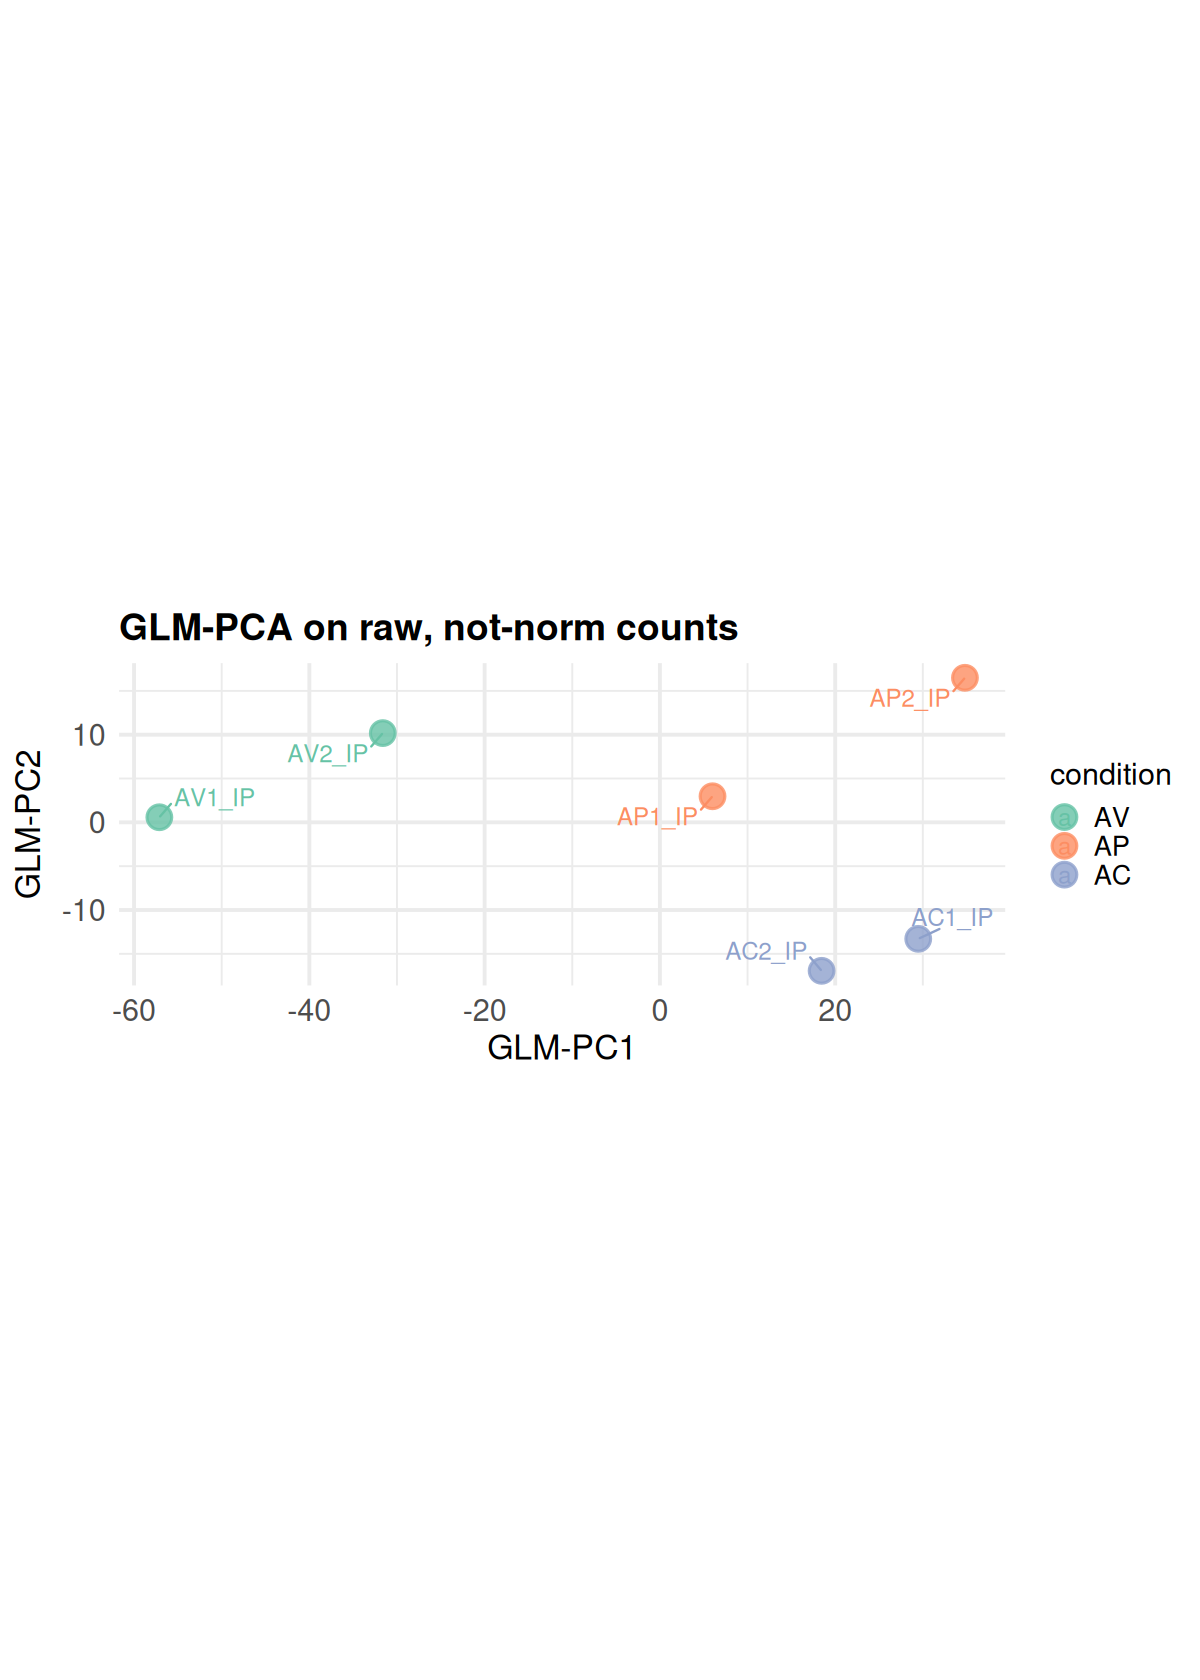

In [60]:
print("perform GLM-PCA")

# Extract count matrix from dds
dds_matrix <- assay(dds)
dim(dds_matrix)

# Remove rows (genes) that are all zeros
dds_matrix_filtered <- dds_matrix[rowSums(dds_matrix) > 0, ]
dim(dds_matrix_filtered)

# Run GLM-PCA on the filtered count data
gpca <- glmpca(dds_matrix_filtered, L = 2)
gpca.dat <- as.data.frame(gpca$factors)
gpca.dat$sample <- colnames(dds)

# Assign condition labels from metadata
if ("condition" %in% colnames(colData(dds))) {
  gpca.dat$condition <- colData(dds)$condition
} else {
  stop("Column 'condition' not found in colData(dds). Check available columns.")
}

p <- ggplot(gpca.dat, aes(x = dim1, y = dim2, color = condition)) +
  geom_point(size = 6, alpha = 0.8, stroke = 1) +  
  geom_text_repel(aes(label = sample), size = 5, box.padding = 0.5, max.overlaps = 10) +  
  coord_fixed() +  
  theme_minimal(base_size = 18) +  
  labs(title = "GLM-PCA on raw, not-norm counts", 
       x = "GLM-PC1", y = "GLM-PC2") +
  scale_color_brewer(palette = "Set2") +  
  theme(legend.position = "right",
        plot.title = element_text(size = 22, face = "bold"),
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 18),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 18)) +
  guides(shape = guide_legend(override.aes = list(size = 5)))  

print(p)

[1] "Heatmap of RLOG transformed matrix"


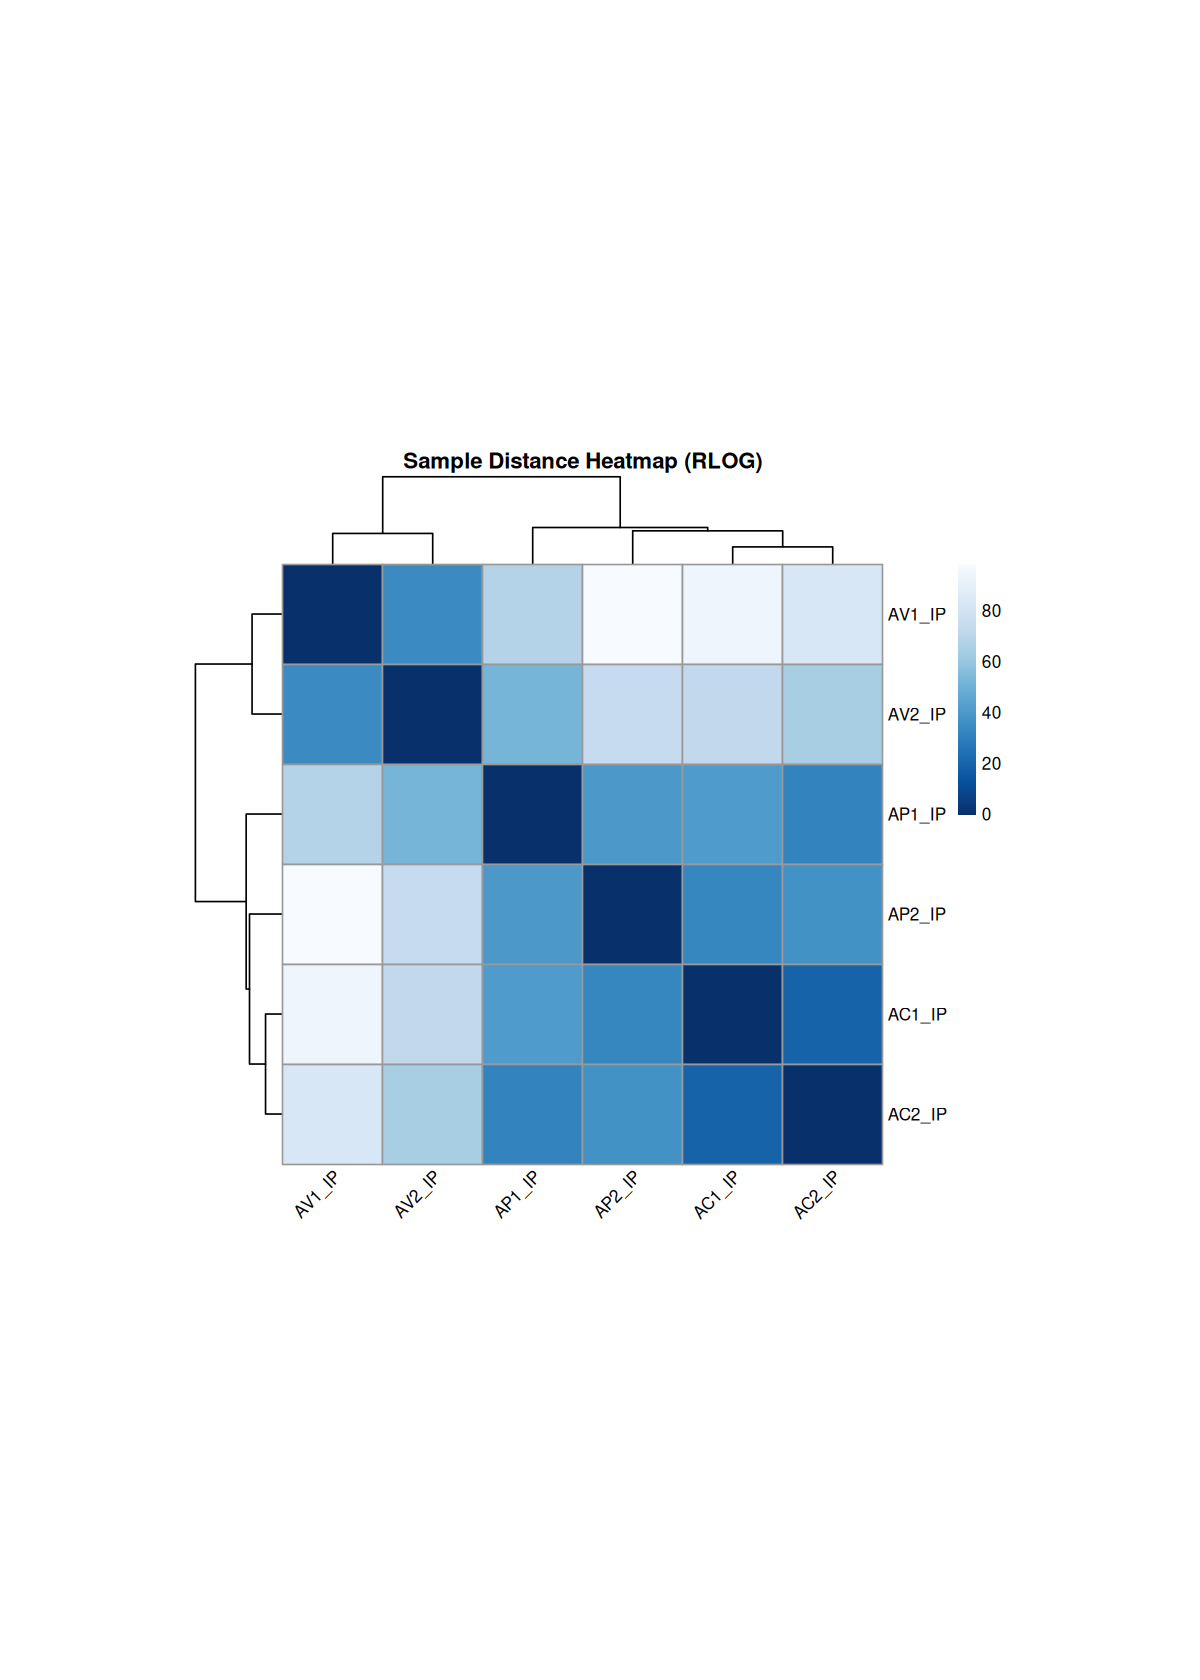

In [65]:
print("Heatmap of RLOG transformed matrix") 

rlog_matrix <- assay(rld)

# Compute Euclidean distance
sampleDists <- dist(t(rlog_matrix))
sampleDistMatrix <- as.matrix(sampleDists)

# Define improved color scheme
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

# Generate Heatmap**
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors,
         fontsize_row = 10,
         fontsize_col = 10,
         cellwidth = 60,
         cellheight = 60,
         angle_col = 45,
         main = "Sample Distance Heatmap (RLOG)")

[1] "Heatmap of VST transformed matrix"


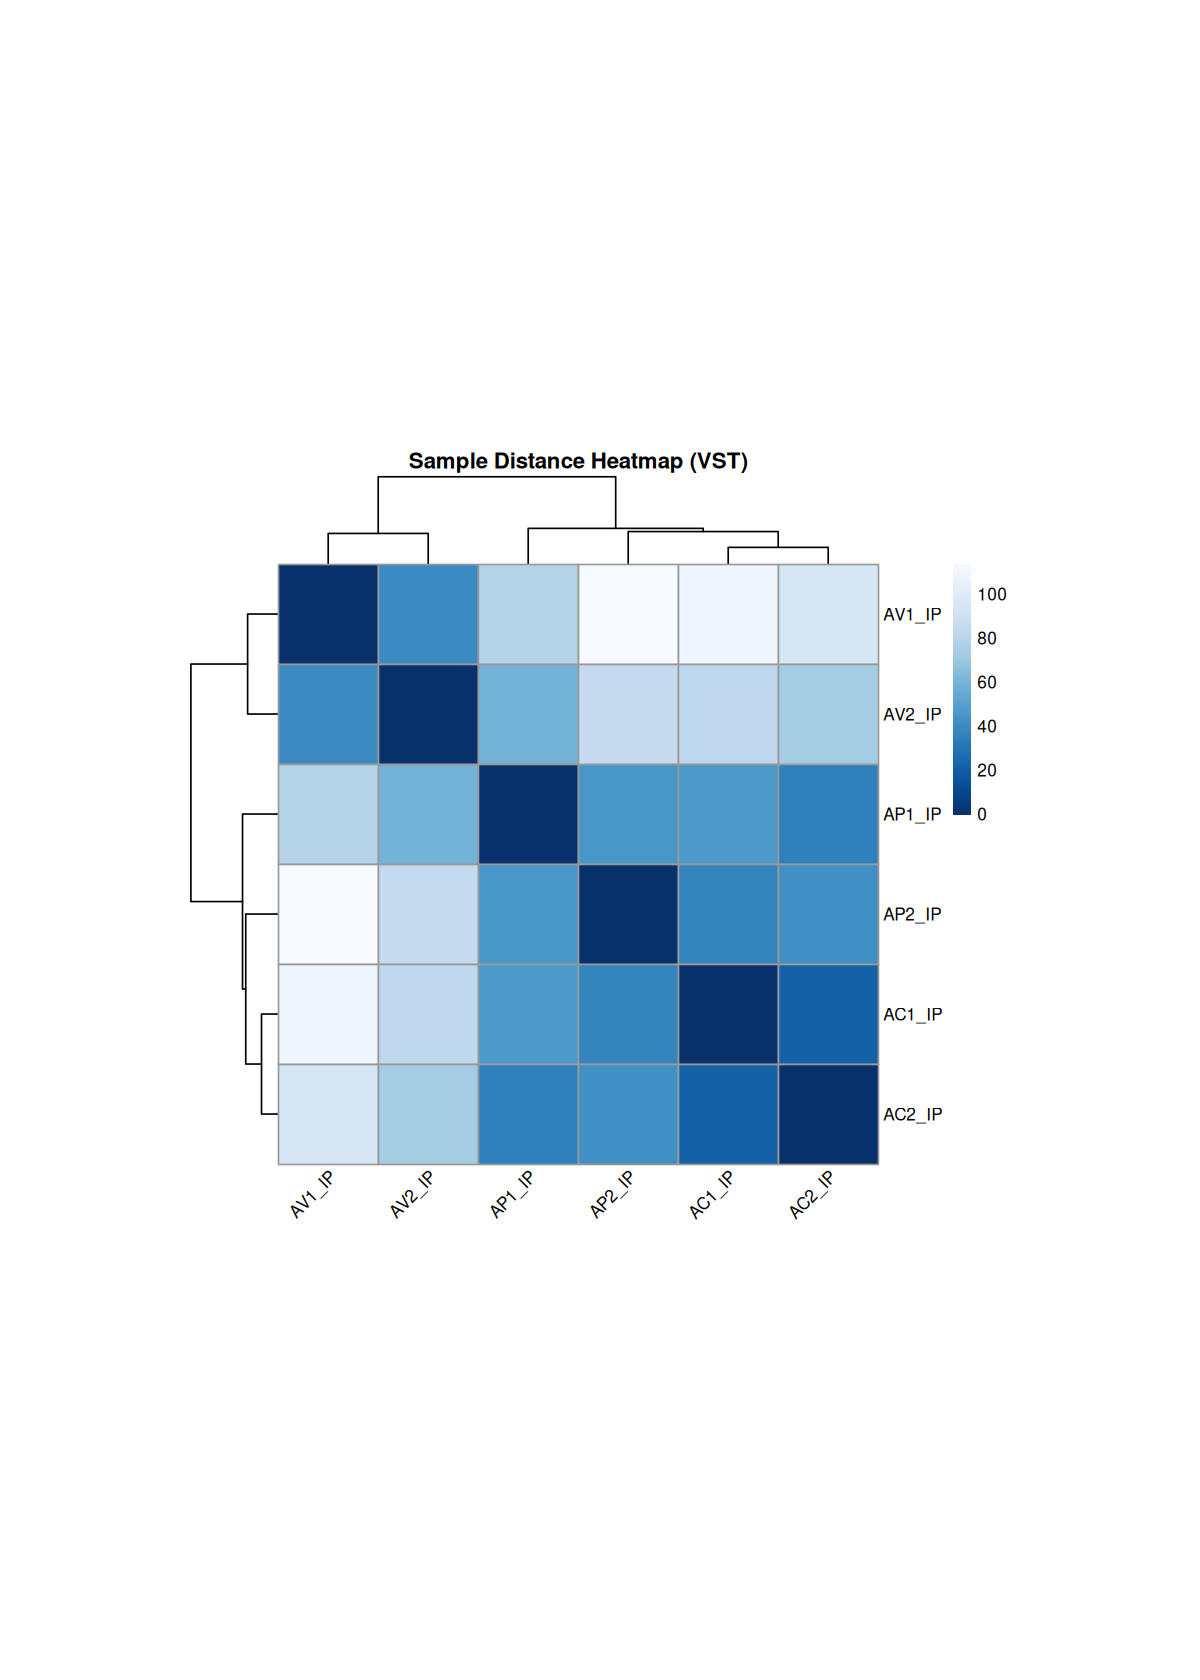

In [62]:
print("Heatmap of VST transformed matrix") 

vsd_matrix <- assay(vsd)  

# Compute Euclidean distance
sampleDists <- dist(t(vsd_matrix))  
sampleDistMatrix <- as.matrix(sampleDists)  

# Define an improved color scheme
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors,
         fontsize_row = 10,  # Make labels readable
         fontsize_col = 10,
         cellwidth = 60,  # Adjust cell size
         cellheight = 60,
         angle_col = 45,  # Rotate column labels for readability
         main = "Sample Distance Heatmap (VST)")

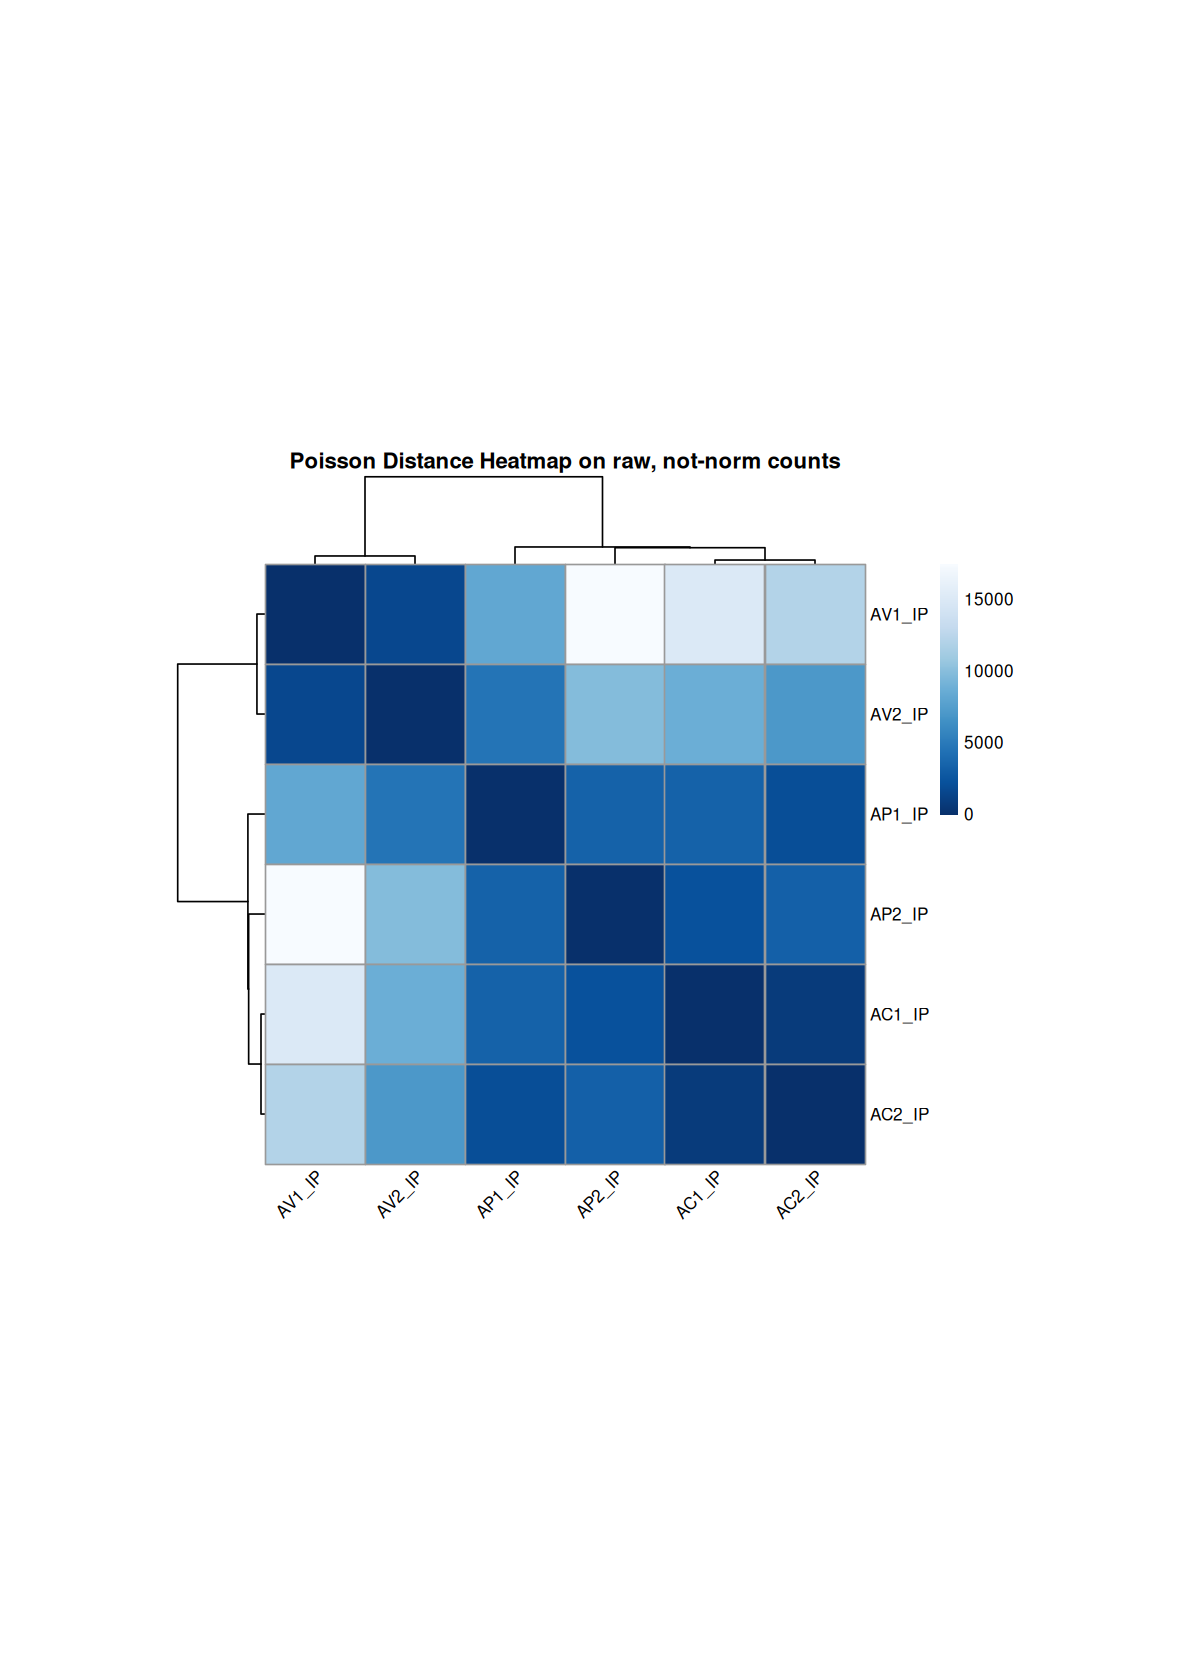

In [66]:
# Another option for calculating sample distances is to use the Poisson Distance (Witten 2011), implemented in the PoiClaClu package.
# This measure of dissimilarity between counts also takes the inherent variance structure of counts into consideration when calculating
# the distances between samples. The PoissonDistance function takes the original count matrix (not normalized) with samples as rows
# instead of columns, so we need to transpose the counts in dds.

library("PoiClaClu")

poisd <- PoissonDistance(t(counts(dds)))
samplePoisDistMatrix <- as.matrix(poisd$dd)

# Extract correct sample names
sample_names <- rownames(colData(dds))  
if (is.null(sample_names)) {
  sample_names <- colnames(dds)
}

# Assign row and column names to keep them in the heatmap
rownames(samplePoisDistMatrix) <- sample_names
colnames(samplePoisDistMatrix) <- sample_names

# Define an improved color scheme
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

# **Generate Heatmap with Proper Labels**
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors,
         fontsize_row = 10,  # Make labels readable
         fontsize_col = 10,
         cellwidth = 60,  # Adjust cell size
         cellheight = 60,
         angle_col = 45,  # Rotate column labels for readability
         main = "Poisson Distance Heatmap on raw, not-norm counts")

In [31]:
# str(dds)

In [61]:
# library("ReportingTools")
# res = results(dds, contrast=c("condition", "AP", "AC"))
# tmp <- tempdir(getwd()) # you would instead use a meaningful path here
# rep <- HTMLReport(shortName = paste("AP.vs.AC", sep="."),  
#                  title = ,
#                  basePath = tmp,
#                  reportDirectory = "report")
# publish(res, rep, dds, n=500, make.plots=TRUE, factor=dds$group)
# finish(rep)

# library("ReportingTools")
# res = results(dds, contrast=c("condition", "AP", "AV"))
# tmp <- tempdir(getwd()) # you would instead use a meaningful path here
# rep <- HTMLReport(shortName = paste("AP.vs.AV", sep="."),  
#                  title = ,
#                  basePath = tmp,
#                  reportDirectory = "report")
# publish(res, rep, dds, n=500, make.plots=TRUE, factor=dds$group)
# finish(rep)

# library("ReportingTools")
# res = results(dds, contrast=c("condition", "AC", "AV"))
# tmp <- tempdir(getwd()) # you would instead use a meaningful path here
# rep <- HTMLReport(shortName = paste("AC.vs.AV", sep="."),  
#                  title = ,
#                  basePath = tmp,
#                  reportDirectory = "report")
# publish(res, rep, dds, n=500, make.plots=TRUE, factor=dds$group)
# finish(rep)

In [67]:
print("SVA analysis")
# SV1, SV2, ... are surrogate variables — latent (hidden) factors estimated from the data that capture unwanted variation 
# (like batch effects, technical noise, or hidden biological subtypes).
# You can think of them as "virtual covariates" — constructed purely from the structure of your data — 
# that explain sources of variation not included in your model (like treatment or condition).

[1] "SVA analysis"


In [68]:
library(sva)
library(RUVSeq)

Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:IRanges':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: 'genefilter'


The following object is masked from 'package:patchwork':

    area


The following objects are masked from 'package:MatrixGenerics':

    rowSds, rowVars


The following objects are masked from 'package:matrixStats':

    rowSds, rowVars


Loading required package: EDASeq

Loading required package: ShortRead

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicAlignments


Attaching package: 'ShortRead'


The following objects are masked from 'package:ReportingTools':

    basePath, name


Loading req

In [69]:
############################################################################################################################### using SVAseq

dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ condition, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))

svseq <- svaseq(dat, mod, mod0, n.sv = 2)
head(svseq$sv, 2)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

0.3829602,-0.2717210
0.2528217,-0.4878352


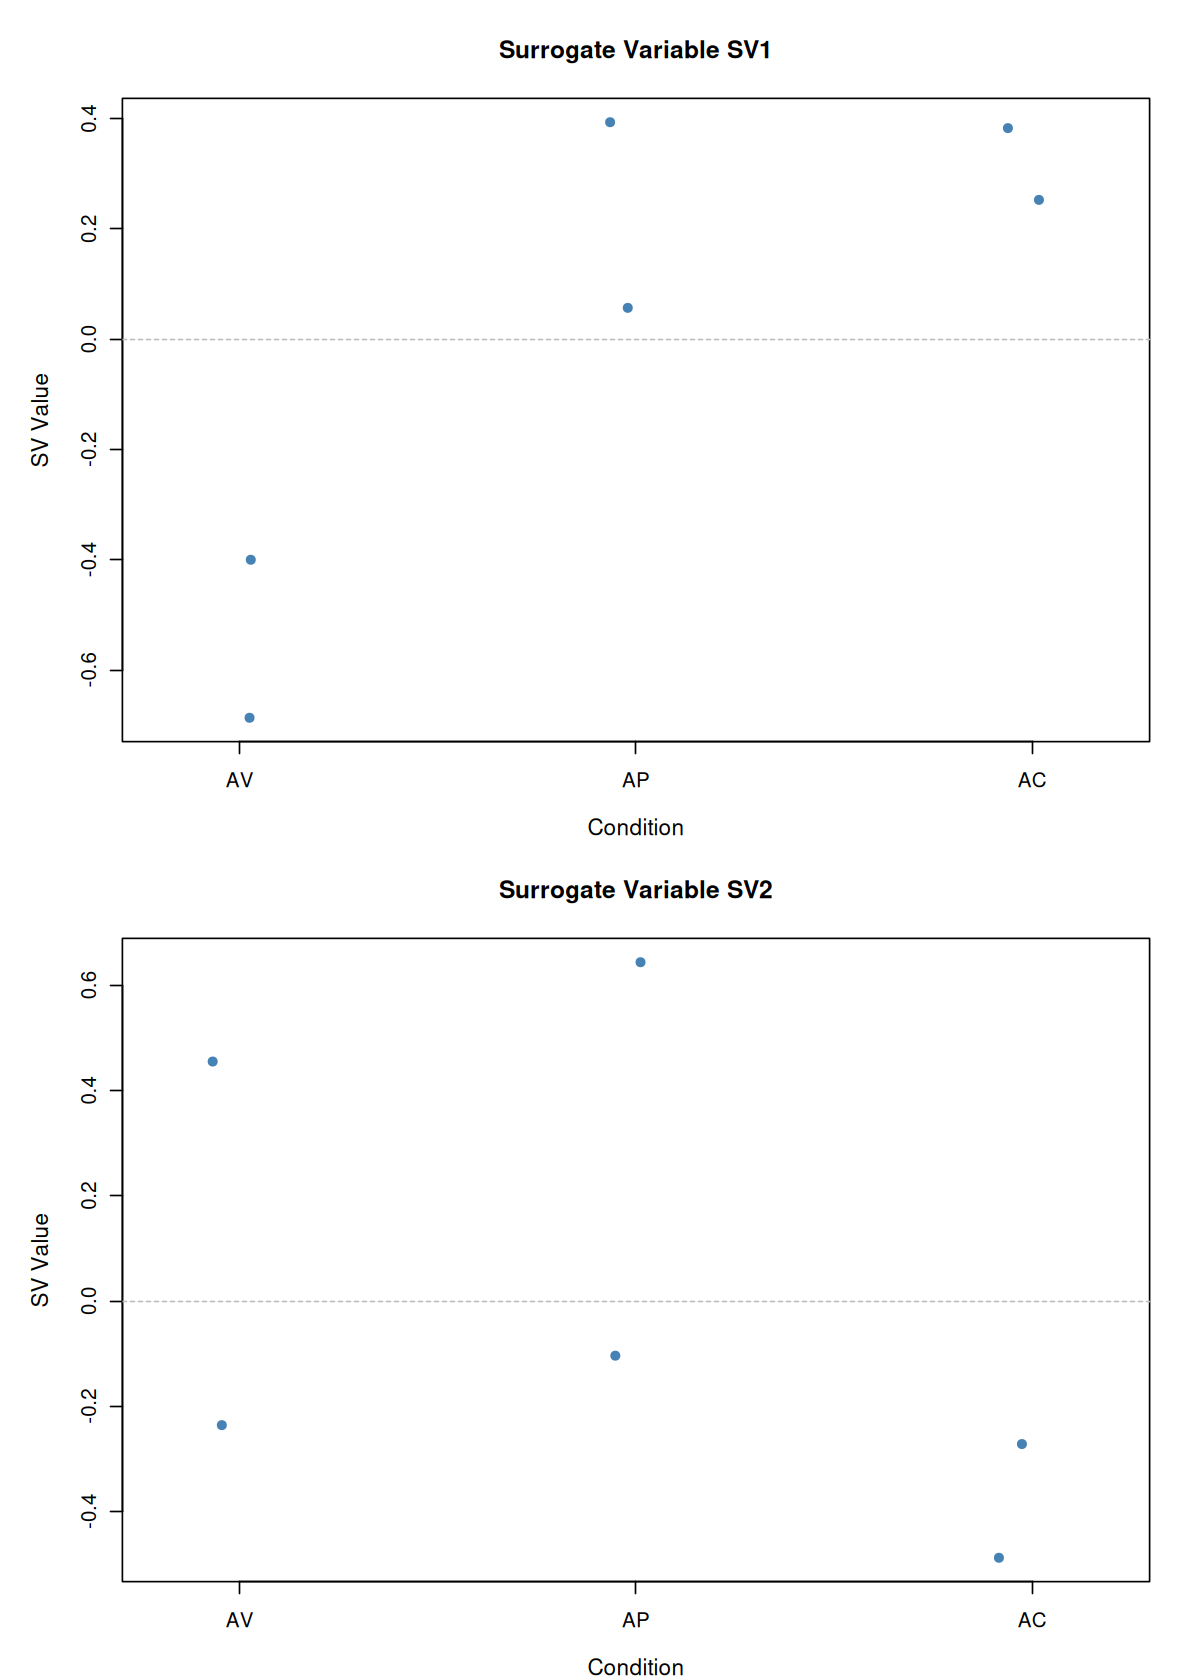

In [70]:
par(mfrow = c(2, 1),           # 2 rows, 1 column layout
    mar = c(4, 5, 4, 2) + 0.1, # bottom, left, top, right margins
    cex.main = 1.2,            # title size
    cex.axis = 1,              # axis label size
    cex.lab = 1.1)             # axis title size

for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$condition,
             vertical = TRUE,
             method = "jitter",
             pch = 16,
             col = "steelblue",
             main = paste0("Surrogate Variable SV", i),
             ylab = "SV Value",
             xlab = "Condition")
  abline(h = 0, lty = 2, col = "gray")
}


In [71]:
# Finally, in order to use SVA to remove any effect on the counts from our surrogate variables, we simply add these two surrogate variables 
# as columns to the DESeqDataSet and then add them to the design:

ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + condition
  
ddssva$SV1
ddssva$SV2

# length(ddssva$SV1)
# length(ddssva$SV2)

ddssva <- DESeq(ddssva)
resultsNames(ddssva)

# rowRanges(ddssva)
# colData(ddssva)
# assays(ddssva)
# assay(ddssva)
# length(rowRanges(ddssva))

res_ddssva <- results(ddssva)
resultsNames(res_ddssva)

# Get results for different comparisons
res_ddssva_AP_vs_AC <- results(ddssva, contrast = c("condition", "AP", "AC"))
res_ddssva_AP_vs_AV <- results(ddssva, contrast = c("condition", "AP", "AV"))
res_ddssva_AC_vs_AV <- results(ddssva, contrast = c("condition", "AC", "AV"))

summary(res_ddssva_AP_vs_AV)
summary(res_ddssva_AC_vs_AV)
summary(res_ddssva_AP_vs_AC)

# Save results
write.csv(as.data.frame(res_ddssva_AP_vs_AC), file = "A549.DESeq2_AP_vs_AC_results.sva.csv")
write.csv(as.data.frame(res_ddssva_AP_vs_AV), file = "A549.DESeq2_AP_vs_AV_results.sva.csv")
write.csv(as.data.frame(res_ddssva_AC_vs_AV), file = "A549.DESeq2_AC_vs_AV_results.sva.csv")

###########################################################
###########################################################

print("number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05")
dim(subset(res_ddssva_AP_vs_AC, pvalue < 0.05))
dim(subset(res_ddssva_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05")
dim(subset(res_ddssva_AP_vs_AV, pvalue < 0.05))
dim(subset(res_ddssva_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05")
dim(subset(res_ddssva_AC_vs_AV, pvalue < 0.05))
dim(subset(res_ddssva_AC_vs_AV, padj < 0.1))

########################################################################################################################
########################################################################################################################

[1]  0.38296023  0.25282174  0.05697049  0.39365777 -0.68650018 -0.39991005

[1] -0.2717210 -0.4878352 -0.1037735  0.6439130 -0.2357767  0.4551933

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"          "SV1"                "SV2"               
[4] "condition_AP_vs_AV" "condition_AC_vs_AV"

character(0)


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05"


[1] 19  6

[1] 0 6

[1] "number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05"


[1] 41  6

[1] 0 6

[1] "number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05"


[1] 26  6

[1] 0 6

using ntop=500 top features by variance

using ntop=500 top features by variance



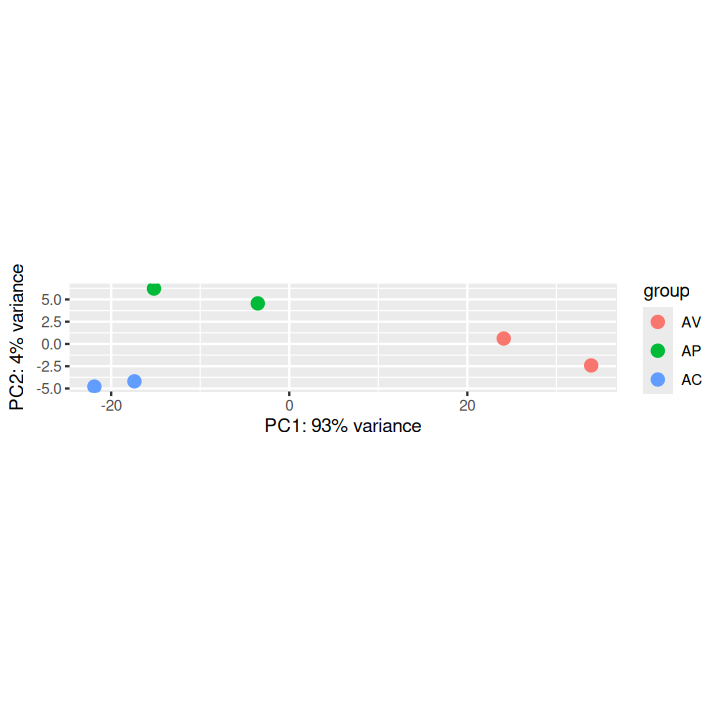

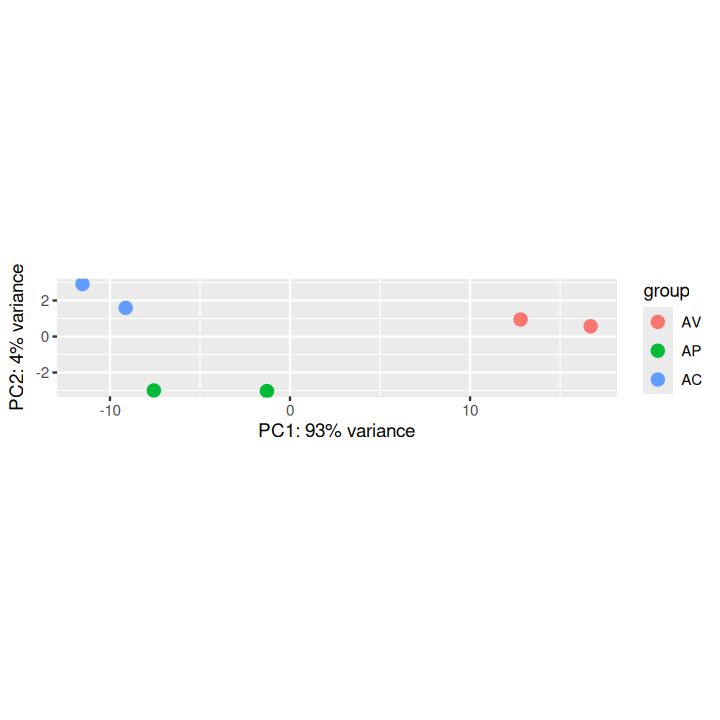

In [72]:
options(repr.plot.width = 6, repr.plot.height = 6)
vsd2 <- vst(ddssva, blind=TRUE)
plotPCA(vsd2, "condition")

options(repr.plot.width = 6, repr.plot.height = 6)
rld2 <- rlog(ddssva, blind = TRUE)
plotPCA(rld2, "condition")

# We would then run DESeq with the new design to re-estimate the parameters and results.

In [73]:
print("RUVseq analysis")

[1] "RUVseq analysis"


,W_1,W_2
,<dbl>,<dbl>
AC1_IP,-0.17725748,-0.32999249
AC2_IP,0.09499302,0.02415052
AP1_IP,0.06420882,0.72563383
AP2_IP,-0.70554616,0.13852314
AV1_IP,0.67472116,0.02819471
AV2_IP,0.04888063,-0.58650972


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"          "W1"                 "W2"                
[4] "condition_AP_vs_AV" "condition_AC_vs_AV"

character(0)


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 21, 0.16%
LFC < 0 (down)     : 8, 0.062%
outliers [1]       : 0, 0%
low counts [2]     : 9265, 72%
(mean count < 1465)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 700, 5.4%
LFC < 0 (down)     : 342, 2.6%
outliers [1]       : 0, 0%
low counts [2]     : 3506, 27%
(mean count < 275)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12916 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14, 0.11%
LFC < 0 (down)     : 4, 0.031%
outliers [1]       : 0, 0%
low counts [2]     : 251, 1.9%
(mean count < 35)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05"


[1] 235   6

[1] 18  6

[1] "number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05"


[1] 371   6

[1] 29  6

[1] "number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05"


[1] 2068    6

[1] 1042    6

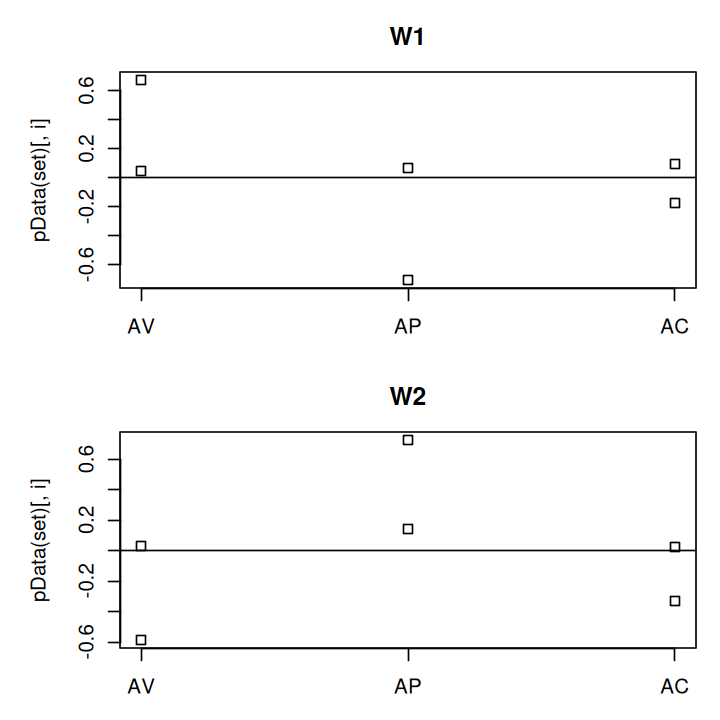

In [74]:
set <- newSeqExpressionSet(counts(dds))
idx  <- rowSums(counts(set) > 5) >= 2
set  <- set[idx, ]
set <- betweenLaneNormalization(set, which="upper")
not.sig <- rownames(res)[which(res$pvalue > .1)]
empirical <- rownames(set)[ rownames(set) %in% not.sig ]
set <- RUVg(set, empirical, k=2)
pData(set)

par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(pData(set)[, i] ~ dds$condition, vertical = TRUE, main = paste0("W", i))
  abline(h = 0)
 }

ddsruv <- dds
ddsruv$W1 <- set$W_1
ddsruv$W2 <- set$W_2
design(ddsruv) <- ~ W1 + W2 + condition

# We would then run DESeq with the new design to re-estimate the parameters and results.
# length(ddsruv$SV1)
# length(ddsruv$SV2)

ddsruv <- DESeq(ddsruv)
resultsNames(ddsruv)

# rowRanges(ddsruv)
# colData(ddsruv)
# assays(ddsruv)
# assay(ddsruv)
# length(rowRanges(ddsruv))

res_ddsruv <- results(ddsruv)
resultsNames(res_ddsruv)

# Get results for different comparisons
res_ddsruv_AP_vs_AC <- results(ddsruv, contrast = c("condition", "AP", "AC"))
res_ddsruv_AP_vs_AV <- results(ddsruv, contrast = c("condition", "AP", "AV"))
res_ddsruv_AC_vs_AV <- results(ddsruv, contrast = c("condition", "AC", "AV"))

summary(res_ddsruv_AP_vs_AV)
summary(res_ddsruv_AC_vs_AV)
summary(res_ddsruv_AP_vs_AC)

# Save results
write.csv(as.data.frame(res_ddsruv_AP_vs_AC), file = "A549.DESeq2_AP_vs_AC_results.ruv.csv")
write.csv(as.data.frame(res_ddsruv_AP_vs_AV), file = "A549.DESeq2_AP_vs_AV_results.ruv.csv")
write.csv(as.data.frame(res_ddsruv_AC_vs_AV), file = "A549.DESeq2_AC_vs_AV_results.ruv.csv")

###########################################################
###########################################################

print("number of differentially bound and expressed transcripts : AP vs AC : pvalue < 0.05")
dim(subset(res_ddsruv_AP_vs_AC, pvalue < 0.05))
dim(subset(res_ddsruv_AP_vs_AC, padj < 0.1))

print("number of differentially bound and expressed transcripts : AP vs AV : pvalue < 0.05")
dim(subset(res_ddsruv_AP_vs_AV, pvalue < 0.05))
dim(subset(res_ddsruv_AP_vs_AV, padj < 0.1))

print("number of differentially bound and expressed transcripts : AC vs AV : pvalue < 0.05")
dim(subset(res_ddsruv_AC_vs_AV, pvalue < 0.05))
dim(subset(res_ddsruv_AC_vs_AV, padj < 0.1))